<a href="https://colab.research.google.com/github/ThiagoKoscak/PUCRJ/blob/main/SteelPlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desafio Playground Series S4E3**

Os dados e problema foram retirados de uma competição no kaggle "Playground Series S4E3" (https://www.kaggle.com/competitions/playground-series-s4e3)

## **Contexto do Problema**
O desafio é centrado em torno da previsão de múltiplas falhas em placas de aço, um problema comum na indústria de manufatura. O conjunto de dados para esta competição foi gerado a partir de um modelo de deep learning treinado no dataset "Steel Plates Faults" da UCI, que por sua vez é baseado em dados reais de falhas em placas de aço. Embora as distribuições das características sejam próximas, elas não são exatamente as mesmas que as do conjunto de dados original.

O foco do desafio é construir um modelo de machine learning que possa preve a probabilidade de cada uma das sete falhas binárias diferentes. Este é um problema de classificação multilabel, onde cada placa de aço pode ter mais de um tipo de falha ou nenhuma.

## **Dados**
Os dados para este desafio são divididos em dois arquivos:

**train.csv**: O conjunto de treinamento contendo as características e os rótulos para as falhas. Cada linha representa uma placa de aço única, com várias características descritivas seguidas por sete colunas binárias indicando a presença ou ausência de cada tipo de falha (Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults).

**test.csv**: O conjunto de teste com os dados não rotulados.

**sample_submission.csv**: Esse conjunto é fornecido para ilustrar o formato correto para a submissão das previsões.

## **Objetivo**
O objetivo deste problema é desenvolver um modelo que possa prever com precisão a presença de cada tipo de falha em placas de aço, com base nas características fornecidas. A avaliação das previsões é feita usando a métrica de Área sob a Curva ROC (AUC-ROC), uma métrica comum para avaliação de modelos de classificação binária e que se encaixa bem nesse problema.

À medida que cada hipótese for apresentada, a nota fornecida pelo Kaggle também será incluída. Esta servirá como uma ilustração da eficiência do modelo, considerando que os rótulos do conjunto de teste não são disponibilizados devido à natureza competitiva do evento.

In [18]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost -q
import xgboost as xgb
!pip install imbalanced-learn -q
from imblearn.over_sampling import SMOTE
!pip install optuna -q
import optuna
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
!pip install kaggle -q
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

In [19]:
# Trazendo os dados disponibilizados pelo desafio:
train_data = pd.read_csv("https://raw.githubusercontent.com/ThiagoKoscak/PUCRJ/main/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/ThiagoKoscak/PUCRJ/main/test.csv")
subs = pd.read_csv("https://raw.githubusercontent.com/ThiagoKoscak/PUCRJ/main//sample_submission.csv")

train_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [20]:
# Verificação das Colunas
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [21]:
# Lista das colunas target
targets=list(subs.columns[1:])
targets

['Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

In [22]:
# Lista de features
features=list(test_data.columns)
features.remove('id')
features

['X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']

In [23]:
print(train_data[targets].value_counts().reset_index())
print("\n")
print(train_data[targets].sum(axis=1).value_counts())

    Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults  count
0        0          0         0       0          0      0             1   6540
1        0          0         0       0          0      1             0   4761
2        0          0         1       0          0      0             0   3411
3        1          0         0       0          0      0             0   1465
4        0          1         0       0          0      0             0   1150
5        0          0         0       0          0      0             0    818
6        0          0         0       1          0      0             0    568
7        0          0         0       0          1      0             0    485
8        0          0         1       0          0      0             1     18
9        0          0         1       0          0      1             0      2
10       1          0         1       0          0      0             0      1


1    18380
0      818
2       21
Name: count, dtyp

In [24]:
# Como os casos onde são apresentados dois problemas ao mesmo tempo são muito raros, decide remove-los por acreditar que não agregam no modelo
target_count = train_data[targets].sum(axis=1)<2
v1= train_data.shape
train_data = train_data[target_count].reset_index(drop=True)
v2= train_data.shape
print("Linhas removidas:", v1[0]-v2[0])

Linhas removidas: 21


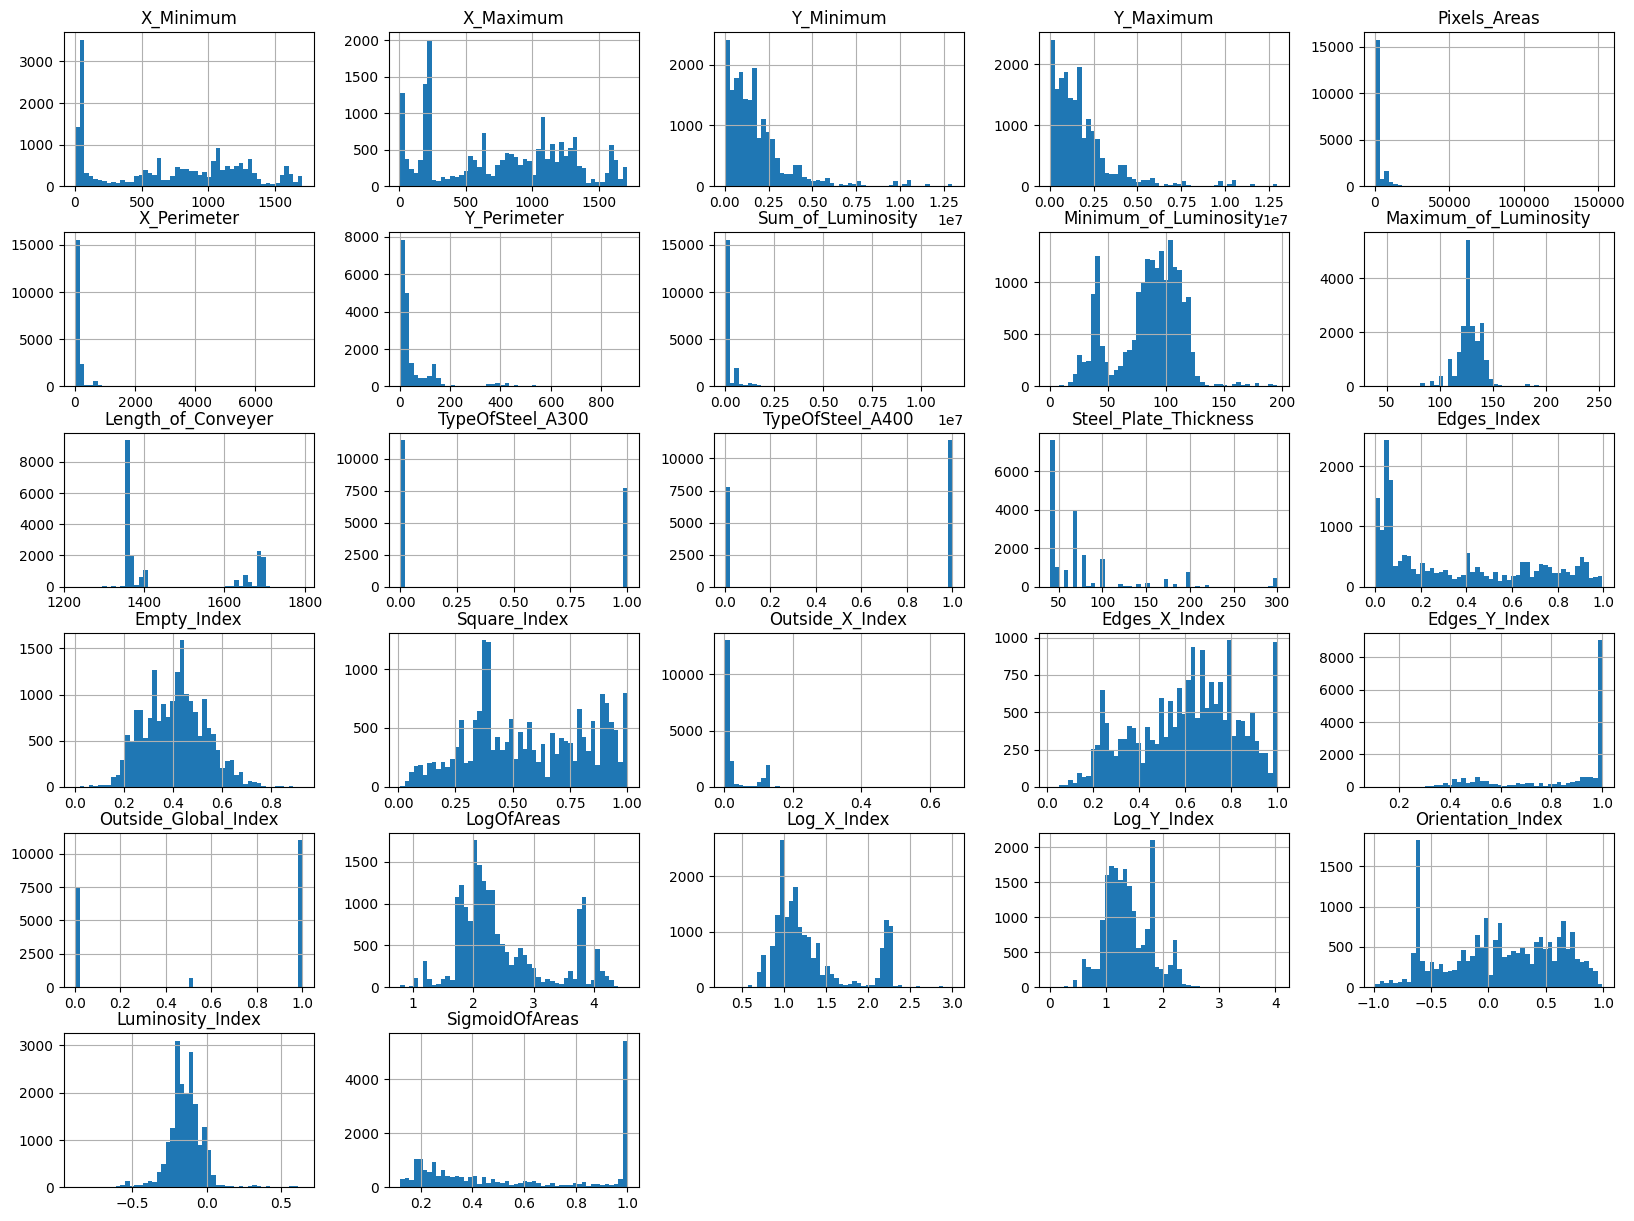

In [25]:
# Histogramas das colunas
train_data[features].hist(bins=50, figsize=(20,15))
plt.show()

In [26]:
# Preparando os dados
X = train_data[features].copy()
y = train_data[targets].copy()

In [27]:
test_size = 0.20 # tamanho do conjunto de teste
np.random.seed(7)  # definindo uma semente global
seed = 7 # semente aleatória

X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Separação em treino e teste por cada uma das targets
for Name in y:
    X_train, X_test, y_train, y_test = train_test_split(X, y[Name], test_size=test_size, shuffle=True, random_state=seed, stratify=y)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Parâmetros e partições da validação cruzada
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

In [28]:
# # Configurações para iteração de modelos
# models = [
#     ('XGB', XGBClassifier(random_state=seed)),
#     #('RF', RandomForestClassifier(random_state=seed)),
#     #('SVC', SVC(probability=True, random_state=seed)),  # probability=True para permitir predict_proba
#     ('KNN', KNeighborsClassifier()),
#     ('LR', LogisticRegression(random_state=seed))
# ]

# # Configurações para iteração de padronização / normalização
# scalers = [None, StandardScaler(), MinMaxScaler()]
# # Configurações para iteração de balanceamento
# samplers = [None, SMOTE(random_state=7)]
# # Configurações para iteração do SelectKbest
# k_values = [10, 20, 'all']

# # Lista para guardar os resultados
# results = []

# # Loop para cada target y / modelo / scaler / samples / KBest
# for X_train, y_train in zip(X_train_list,y_train_list):
#     for model_name, model in models:
#         ## Esse trecho foi uma tentativa de melhorar os modelos dando mais peso para a classe positiva, porém não deram resultado positivo e foram removidos
#         # scale_pos_weight_value = (y_train.size - y_train.sum()) / y_train.sum()
#         # if model_name == 'XGB':
#         #   model.set_params(scale_pos_weight=scale_pos_weight_value)
#         # if model_name == 'LR':
#         #   model.set_params(class_weight='balanced')
#         for scaler in scalers:
#             for sampler in samplers:
#                 for k in k_values:
#                     # Criação dos steps da Pipeline
#                     steps = []
#                     # Adicionando o scaler
#                     if scaler is not None:
#                         steps.append(('scaler', scaler))
#                     # Adicionando o sampler
#                     if sampler is not None:
#                         steps.append(('sampler', sampler))
#                     # Adicionando SelectKBest
#                     steps.append(('selectkbest', SelectKBest(score_func=f_classif, k=k)))
#                     # Adicionando o modelo
#                     steps.append(('classifier', model))

#                     pipeline = imblearnPipeline(steps=steps)

#                     # Realizando a validação cruzada
#                     cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=['roc_auc', 'accuracy'])

#                     roc_auc_mean = np.mean(cv_results['test_roc_auc'])
#                     accuracy_mean = np.mean(cv_results['test_accuracy'])

#                     # Armazenando os resultados, incluindo o valor de k
#                     results.append({
#                         'target': y_train.name,
#                         'model': model_name,
#                         'scaler': 'None' if scaler is None else scaler.__class__.__name__,
#                         'sampler': 'None' if sampler is None else 'SMOTE',
#                         'k': k,
#                         'roc_auc': roc_auc_mean,
#                         'accuracy': accuracy_mean
#                     })

# # Imprimindo cada resultado individualmente
# for result in results:
#     print(f"Target: {result['target']}, Model: {result['model']}, Scaler: {result['scaler']}, Sampler: {result['sampler']}, KBest: {result['k']}, ROC AUC: {result['roc_auc']:.4f}, Accuracy: {result['accuracy']:.4f}")

# # Imprimindo o Top 10 Combinações Globais
# global_averages = {}
# for result in results:
#     combination_key = (result['model'], result['scaler'], result['sampler'], result['k'])
#     if combination_key not in global_averages:
#         global_averages[combination_key] = {'roc_auc': [], 'accuracy': []}
#     global_averages[combination_key]['roc_auc'].append(result['roc_auc'])
#     global_averages[combination_key]['accuracy'].append(result['accuracy'])

# for key, value in global_averages.items():
#     avg_roc_auc = sum(value['roc_auc']) / len(value['roc_auc'])
#     avg_accuracy = sum(value['accuracy']) / len(value['accuracy'])
#     value['avg_roc_auc'] = avg_roc_auc
#     value['avg_accuracy'] = avg_accuracy

# # Ordenando as combinações gerais pela média de ROC AUC em ordem decrescente
# sorted_global_combinations = sorted(global_averages.items(), key=lambda x: x[1]['avg_roc_auc'], reverse=True)

# print("\nTop 10 Combinações Gerais Baseadas na Média do ROC AUC:")
# for i, ((model, scaler, sampler, k), metrics) in enumerate(sorted_global_combinations[:10], start=1):
#     print(f"{i}. Modelo: {model}, Scaler: {'No Scaler' if scaler == 'None' else scaler}, Sampler: {'No Sampler' if sampler == 'None' else 'SMOTE'}, KBest: {k}, Média ROC AUC: {metrics['avg_roc_auc']:.4f}, Média de Acurácia: {metrics['avg_accuracy']:.4f}")

# # Imprimindo a melhor combinação por Target para avaliar desempenho individual
# best_combinations_by_target = {}
# for target_name in y.columns:
#     target_results = [result for result in results if result['target'] == target_name]
#     best_combination = max(target_results, key=lambda x: x['roc_auc'])
#     best_combinations_by_target[target_name] = best_combination

# print("\nMelhor Combinação por Target Baseada no ROC AUC:")
# for target_name, best_combination in best_combinations_by_target.items():
#     print(f"Target: {target_name}, Modelo: {best_combination['model']}, Scaler: {best_combination['scaler']}, Sampler: {best_combination['sampler']}, KBest: {best_combination['k']}, ROC AUC: {best_combination['roc_auc']:.4f}, Acurácia: {best_combination['accuracy']:.4f}")

# # Imprimindo a média geral de ROC AUC e Acurácia das melhores combinações por target
# roc_auc_values = [best_combination['roc_auc'] for best_combination in best_combinations_by_target.values()]
# accuracy_values = [best_combination['accuracy'] for best_combination in best_combinations_by_target.values()]
# avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)
# avg_accuracy = sum(accuracy_values) / len(accuracy_values)

# print(f"\nMédia de ROC AUC para as melhores combinações por Target: {avg_roc_auc:.4f}")
# print(f"Média de Acurácia para as melhores combinações por Target: {avg_accuracy:.4f}")



**Essa é a saída do código acima, foi comentado por demorar cerca de 30 min.
Saída:**

```
Target: Pastry, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.8365, Accuracy: 0.9170
Target: Pastry, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.8477, Accuracy: 0.9185
Target: Pastry, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.8492, Accuracy: 0.9198
Target: Pastry, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8332, Accuracy: 0.9007
Target: Pastry, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8419, Accuracy: 0.9062
Target: Pastry, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.8478, Accuracy: 0.9103
Target: Pastry, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.8365, Accuracy: 0.9170
Target: Pastry, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.8477, Accuracy: 0.9185
Target: Pastry, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.8492, Accuracy: 0.9198
Target: Pastry, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8360, Accuracy: 0.9032
Target: Pastry, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8400, Accuracy: 0.9083
Target: Pastry, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8472, Accuracy: 0.9083
Target: Pastry, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.8365, Accuracy: 0.9170
Target: Pastry, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.8477, Accuracy: 0.9185
Target: Pastry, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.8492, Accuracy: 0.9198
Target: Pastry, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8357, Accuracy: 0.9033
Target: Pastry, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8402, Accuracy: 0.9092
Target: Pastry, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8439, Accuracy: 0.9089
Target: Pastry, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.6171, Accuracy: 0.9152
Target: Pastry, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.5970, Accuracy: 0.9175
Target: Pastry, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.5400, Accuracy: 0.9193
Target: Pastry, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6836, Accuracy: 0.7537
Target: Pastry, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6436, Accuracy: 0.6983
Target: Pastry, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.5531, Accuracy: 0.6985
Target: Pastry, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.7179, Accuracy: 0.9118
Target: Pastry, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.7207, Accuracy: 0.9128
Target: Pastry, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.7267, Accuracy: 0.9157
Target: Pastry, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7868, Accuracy: 0.7638
Target: Pastry, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7690, Accuracy: 0.7689
Target: Pastry, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7695, Accuracy: 0.7707
Target: Pastry, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.7076, Accuracy: 0.9123
Target: Pastry, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.7333, Accuracy: 0.9142
Target: Pastry, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.7213, Accuracy: 0.9141
Target: Pastry, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7827, Accuracy: 0.7629
Target: Pastry, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7684, Accuracy: 0.7679
Target: Pastry, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7598, Accuracy: 0.7730
Target: Pastry, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.8364, Accuracy: 0.9230
Target: Pastry, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.7205, Accuracy: 0.9221
Target: Pastry, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.5276, Accuracy: 0.9236
Target: Pastry, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8379, Accuracy: 0.7142
Target: Pastry, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7713, Accuracy: 0.6676
Target: Pastry, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.6315, Accuracy: 0.4015
Target: Pastry, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.8464, Accuracy: 0.9236
Target: Pastry, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.8507, Accuracy: 0.9232
Target: Pastry, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.8591, Accuracy: 0.9231
Target: Pastry, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8460, Accuracy: 0.7026
Target: Pastry, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8494, Accuracy: 0.7180
Target: Pastry, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8578, Accuracy: 0.7313
Target: Pastry, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.8459, Accuracy: 0.9234
Target: Pastry, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.8492, Accuracy: 0.9236
Target: Pastry, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.8579, Accuracy: 0.9241
Target: Pastry, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8457, Accuracy: 0.7015
Target: Pastry, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8494, Accuracy: 0.7155
Target: Pastry, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8581, Accuracy: 0.7323
Target: Z_Scratch, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9234, Accuracy: 0.9480
Target: Z_Scratch, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9272, Accuracy: 0.9465
Target: Z_Scratch, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9544, Accuracy: 0.9520
Target: Z_Scratch, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9188, Accuracy: 0.9357
Target: Z_Scratch, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9242, Accuracy: 0.9434
Target: Z_Scratch, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9496, Accuracy: 0.9495
Target: Z_Scratch, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9234, Accuracy: 0.9480
Target: Z_Scratch, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9272, Accuracy: 0.9465
Target: Z_Scratch, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9544, Accuracy: 0.9520
Target: Z_Scratch, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9173, Accuracy: 0.9334
Target: Z_Scratch, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9252, Accuracy: 0.9432
Target: Z_Scratch, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9498, Accuracy: 0.9512
Target: Z_Scratch, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9234, Accuracy: 0.9480
Target: Z_Scratch, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9272, Accuracy: 0.9465
Target: Z_Scratch, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9544, Accuracy: 0.9520
Target: Z_Scratch, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9202, Accuracy: 0.9338
Target: Z_Scratch, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9259, Accuracy: 0.9447
Target: Z_Scratch, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9501, Accuracy: 0.9520
Target: Z_Scratch, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.7374, Accuracy: 0.9341
Target: Z_Scratch, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.6934, Accuracy: 0.9333
Target: Z_Scratch, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.5537, Accuracy: 0.9376
Target: Z_Scratch, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8224, Accuracy: 0.7676
Target: Z_Scratch, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7855, Accuracy: 0.7442
Target: Z_Scratch, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.5727, Accuracy: 0.7396
Target: Z_Scratch, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.8065, Accuracy: 0.9420
Target: Z_Scratch, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.8005, Accuracy: 0.9440
Target: Z_Scratch, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.8226, Accuracy: 0.9431
Target: Z_Scratch, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8482, Accuracy: 0.8345
Target: Z_Scratch, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8331, Accuracy: 0.8461
Target: Z_Scratch, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8438, Accuracy: 0.8525
Target: Z_Scratch, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.8106, Accuracy: 0.9424
Target: Z_Scratch, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.8085, Accuracy: 0.9427
Target: Z_Scratch, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.8221, Accuracy: 0.9432
Target: Z_Scratch, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8538, Accuracy: 0.8317
Target: Z_Scratch, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8394, Accuracy: 0.8468
Target: Z_Scratch, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8427, Accuracy: 0.8520
Target: Z_Scratch, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.8629, Accuracy: 0.9392
Target: Z_Scratch, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.7660, Accuracy: 0.9400
Target: Z_Scratch, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.7603, Accuracy: 0.9402
Target: Z_Scratch, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8138, Accuracy: 0.7925
Target: Z_Scratch, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7339, Accuracy: 0.6813
Target: Z_Scratch, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.7061, Accuracy: 0.6903
Target: Z_Scratch, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9078, Accuracy: 0.9442
Target: Z_Scratch, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9149, Accuracy: 0.9451
Target: Z_Scratch, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9137, Accuracy: 0.9474
Target: Z_Scratch, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9042, Accuracy: 0.8135
Target: Z_Scratch, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9125, Accuracy: 0.8200
Target: Z_Scratch, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9127, Accuracy: 0.8200
Target: Z_Scratch, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9005, Accuracy: 0.9435
Target: Z_Scratch, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9118, Accuracy: 0.9447
Target: Z_Scratch, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9101, Accuracy: 0.9461
Target: Z_Scratch, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9048, Accuracy: 0.8164
Target: Z_Scratch, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9124, Accuracy: 0.8228
Target: Z_Scratch, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9128, Accuracy: 0.8217
Target: K_Scatch, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9704, Accuracy: 0.9558
Target: K_Scatch, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9830, Accuracy: 0.9617
Target: K_Scatch, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9834, Accuracy: 0.9613
Target: K_Scatch, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9694, Accuracy: 0.9524
Target: K_Scatch, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9816, Accuracy: 0.9586
Target: K_Scatch, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9821, Accuracy: 0.9596
Target: K_Scatch, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9704, Accuracy: 0.9558
Target: K_Scatch, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9830, Accuracy: 0.9617
Target: K_Scatch, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9834, Accuracy: 0.9613
Target: K_Scatch, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9673, Accuracy: 0.9521
Target: K_Scatch, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9817, Accuracy: 0.9592
Target: K_Scatch, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9820, Accuracy: 0.9592
Target: K_Scatch, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9704, Accuracy: 0.9558
Target: K_Scatch, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9830, Accuracy: 0.9617
Target: K_Scatch, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9834, Accuracy: 0.9613
Target: K_Scatch, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9673, Accuracy: 0.9527
Target: K_Scatch, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9820, Accuracy: 0.9587
Target: K_Scatch, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9822, Accuracy: 0.9590
Target: K_Scatch, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9379, Accuracy: 0.9439
Target: K_Scatch, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9380, Accuracy: 0.9460
Target: K_Scatch, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9211, Accuracy: 0.9387
Target: K_Scatch, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9397, Accuracy: 0.9349
Target: K_Scatch, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9454, Accuracy: 0.9301
Target: K_Scatch, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9191, Accuracy: 0.9146
Target: K_Scatch, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9489, Accuracy: 0.9533
Target: K_Scatch, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9591, Accuracy: 0.9598
Target: K_Scatch, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9577, Accuracy: 0.9579
Target: K_Scatch, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9494, Accuracy: 0.9314
Target: K_Scatch, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9589, Accuracy: 0.9368
Target: K_Scatch, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9561, Accuracy: 0.9327
Target: K_Scatch, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9531, Accuracy: 0.9542
Target: K_Scatch, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9559, Accuracy: 0.9603
Target: K_Scatch, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9565, Accuracy: 0.9595
Target: K_Scatch, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9484, Accuracy: 0.9292
Target: K_Scatch, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9548, Accuracy: 0.9366
Target: K_Scatch, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9553, Accuracy: 0.9361
Target: K_Scatch, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9067, Accuracy: 0.9526
Target: K_Scatch, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9596, Accuracy: 0.9570
Target: K_Scatch, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9478, Accuracy: 0.9529
Target: K_Scatch, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9391, Accuracy: 0.9463
Target: K_Scatch, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9695, Accuracy: 0.9538
Target: K_Scatch, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9483, Accuracy: 0.9518
Target: K_Scatch, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9471, Accuracy: 0.9543
Target: K_Scatch, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9757, Accuracy: 0.9598
Target: K_Scatch, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9807, Accuracy: 0.9602
Target: K_Scatch, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9562, Accuracy: 0.9469
Target: K_Scatch, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9761, Accuracy: 0.9452
Target: K_Scatch, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9804, Accuracy: 0.9530
Target: K_Scatch, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9439, Accuracy: 0.9544
Target: K_Scatch, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9751, Accuracy: 0.9604
Target: K_Scatch, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9808, Accuracy: 0.9609
Target: K_Scatch, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9563, Accuracy: 0.9467
Target: K_Scatch, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9767, Accuracy: 0.9460
Target: K_Scatch, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9807, Accuracy: 0.9531
Target: Stains, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9845, Accuracy: 0.9814
Target: Stains, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9923, Accuracy: 0.9849
Target: Stains, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9928, Accuracy: 0.9852
Target: Stains, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9853, Accuracy: 0.9793
Target: Stains, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9913, Accuracy: 0.9848
Target: Stains, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9914, Accuracy: 0.9852
Target: Stains, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9845, Accuracy: 0.9814
Target: Stains, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9923, Accuracy: 0.9849
Target: Stains, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9928, Accuracy: 0.9852
Target: Stains, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9832, Accuracy: 0.9794
Target: Stains, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9915, Accuracy: 0.9842
Target: Stains, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9906, Accuracy: 0.9848
Target: Stains, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9845, Accuracy: 0.9814
Target: Stains, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9923, Accuracy: 0.9849
Target: Stains, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9928, Accuracy: 0.9852
Target: Stains, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9821, Accuracy: 0.9788
Target: Stains, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9916, Accuracy: 0.9839
Target: Stains, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9913, Accuracy: 0.9855
Target: Stains, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9154, Accuracy: 0.9806
Target: Stains, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9489, Accuracy: 0.9835
Target: Stains, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.7860, Accuracy: 0.9726
Target: Stains, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9524, Accuracy: 0.9612
Target: Stains, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9627, Accuracy: 0.9635
Target: Stains, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.8627, Accuracy: 0.9185
Target: Stains, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9282, Accuracy: 0.9807
Target: Stains, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9388, Accuracy: 0.9818
Target: Stains, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9384, Accuracy: 0.9818
Target: Stains, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9492, Accuracy: 0.9617
Target: Stains, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9592, Accuracy: 0.9693
Target: Stains, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9517, Accuracy: 0.9651
Target: Stains, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9201, Accuracy: 0.9805
Target: Stains, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9403, Accuracy: 0.9814
Target: Stains, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9352, Accuracy: 0.9802
Target: Stains, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9496, Accuracy: 0.9609
Target: Stains, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9527, Accuracy: 0.9665
Target: Stains, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9469, Accuracy: 0.9614
Target: Stains, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9849, Accuracy: 0.9826
Target: Stains, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9830, Accuracy: 0.9814
Target: Stains, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9568, Accuracy: 0.9730
Target: Stains, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9855, Accuracy: 0.9603
Target: Stains, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9813, Accuracy: 0.9479
Target: Stains, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9623, Accuracy: 0.8975
Target: Stains, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.9848, Accuracy: 0.9826
Target: Stains, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.9880, Accuracy: 0.9842
Target: Stains, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.9881, Accuracy: 0.9841
Target: Stains, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9853, Accuracy: 0.9559
Target: Stains, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9878, Accuracy: 0.9611
Target: Stains, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9881, Accuracy: 0.9631
Target: Stains, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.9838, Accuracy: 0.9818
Target: Stains, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.9873, Accuracy: 0.9829
Target: Stains, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.9875, Accuracy: 0.9832
Target: Stains, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.9851, Accuracy: 0.9532
Target: Stains, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9879, Accuracy: 0.9588
Target: Stains, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9882, Accuracy: 0.9615
Target: Dirtiness, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.8191, Accuracy: 0.9729
Target: Dirtiness, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.8651, Accuracy: 0.9734
Target: Dirtiness, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.8698, Accuracy: 0.9732
Target: Dirtiness, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8221, Accuracy: 0.9518
Target: Dirtiness, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8493, Accuracy: 0.9620
Target: Dirtiness, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.8607, Accuracy: 0.9680
Target: Dirtiness, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.8191, Accuracy: 0.9729
Target: Dirtiness, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.8651, Accuracy: 0.9734
Target: Dirtiness, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.8698, Accuracy: 0.9732
Target: Dirtiness, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8029, Accuracy: 0.9546
Target: Dirtiness, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8473, Accuracy: 0.9653
Target: Dirtiness, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8556, Accuracy: 0.9692
Target: Dirtiness, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.8191, Accuracy: 0.9729
Target: Dirtiness, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.8651, Accuracy: 0.9734
Target: Dirtiness, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.8698, Accuracy: 0.9732
Target: Dirtiness, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8010, Accuracy: 0.9542
Target: Dirtiness, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8416, Accuracy: 0.9650
Target: Dirtiness, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8583, Accuracy: 0.9704
Target: Dirtiness, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.6494, Accuracy: 0.9738
Target: Dirtiness, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.5998, Accuracy: 0.9731
Target: Dirtiness, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.5453, Accuracy: 0.9734
Target: Dirtiness, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7503, Accuracy: 0.7318
Target: Dirtiness, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7117, Accuracy: 0.7353
Target: Dirtiness, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.5812, Accuracy: 0.7979
Target: Dirtiness, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.6632, Accuracy: 0.9724
Target: Dirtiness, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.6773, Accuracy: 0.9727
Target: Dirtiness, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.6800, Accuracy: 0.9743
Target: Dirtiness, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7459, Accuracy: 0.8353
Target: Dirtiness, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7349, Accuracy: 0.8673
Target: Dirtiness, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7421, Accuracy: 0.8760
Target: Dirtiness, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.6551, Accuracy: 0.9728
Target: Dirtiness, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.6969, Accuracy: 0.9729
Target: Dirtiness, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.6823, Accuracy: 0.9736
Target: Dirtiness, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7440, Accuracy: 0.8233
Target: Dirtiness, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7462, Accuracy: 0.8637
Target: Dirtiness, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7420, Accuracy: 0.8706
Target: Dirtiness, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.8337, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.6799, Accuracy: 0.9745
Target: Dirtiness, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.6689, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8319, Accuracy: 0.7591
Target: Dirtiness, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7868, Accuracy: 0.6989
Target: Dirtiness, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.5529, Accuracy: 0.4274
Target: Dirtiness, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.8344, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.8426, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.8443, Accuracy: 0.9749
Target: Dirtiness, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8346, Accuracy: 0.7334
Target: Dirtiness, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8417, Accuracy: 0.7496
Target: Dirtiness, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8412, Accuracy: 0.7547
Target: Dirtiness, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.8324, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.8400, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.8399, Accuracy: 0.9747
Target: Dirtiness, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.8337, Accuracy: 0.7360
Target: Dirtiness, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.8423, Accuracy: 0.7498
Target: Dirtiness, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.8418, Accuracy: 0.7570
Target: Bumps, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.7242, Accuracy: 0.7412
Target: Bumps, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.7662, Accuracy: 0.7504
Target: Bumps, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.7866, Accuracy: 0.7627
Target: Bumps, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7237, Accuracy: 0.7153
Target: Bumps, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7671, Accuracy: 0.7410
Target: Bumps, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.7865, Accuracy: 0.7577
Target: Bumps, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.7242, Accuracy: 0.7412
Target: Bumps, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.7662, Accuracy: 0.7504
Target: Bumps, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.7866, Accuracy: 0.7627
Target: Bumps, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7200, Accuracy: 0.7175
Target: Bumps, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7606, Accuracy: 0.7344
Target: Bumps, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7839, Accuracy: 0.7584
Target: Bumps, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.7242, Accuracy: 0.7412
Target: Bumps, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.7662, Accuracy: 0.7504
Target: Bumps, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.7866, Accuracy: 0.7627
Target: Bumps, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7196, Accuracy: 0.7162
Target: Bumps, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7620, Accuracy: 0.7367
Target: Bumps, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7852, Accuracy: 0.7586
Target: Bumps, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.6522, Accuracy: 0.7091
Target: Bumps, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.6654, Accuracy: 0.7157
Target: Bumps, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.6235, Accuracy: 0.7069
Target: Bumps, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6527, Accuracy: 0.6334
Target: Bumps, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6829, Accuracy: 0.6421
Target: Bumps, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.6280, Accuracy: 0.6019
Target: Bumps, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.6633, Accuracy: 0.7139
Target: Bumps, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.7113, Accuracy: 0.7328
Target: Bumps, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.7242, Accuracy: 0.7409
Target: Bumps, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6716, Accuracy: 0.6242
Target: Bumps, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7110, Accuracy: 0.6483
Target: Bumps, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7218, Accuracy: 0.6524
Target: Bumps, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.6648, Accuracy: 0.7110
Target: Bumps, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.7060, Accuracy: 0.7301
Target: Bumps, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.7235, Accuracy: 0.7356
Target: Bumps, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6719, Accuracy: 0.6275
Target: Bumps, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7092, Accuracy: 0.6462
Target: Bumps, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7214, Accuracy: 0.6527
Target: Bumps, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.7083, Accuracy: 0.7504
Target: Bumps, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.6977, Accuracy: 0.7473
Target: Bumps, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.6394, Accuracy: 0.7519
Target: Bumps, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6444, Accuracy: 0.6912
Target: Bumps, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7010, Accuracy: 0.5525
Target: Bumps, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.6757, Accuracy: 0.4939
Target: Bumps, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.7210, Accuracy: 0.7494
Target: Bumps, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.7602, Accuracy: 0.7582
Target: Bumps, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.7665, Accuracy: 0.7623
Target: Bumps, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7155, Accuracy: 0.5999
Target: Bumps, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7591, Accuracy: 0.6525
Target: Bumps, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7655, Accuracy: 0.6572
Target: Bumps, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.7098, Accuracy: 0.7521
Target: Bumps, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.7483, Accuracy: 0.7597
Target: Bumps, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.7555, Accuracy: 0.7608
Target: Bumps, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.7167, Accuracy: 0.6209
Target: Bumps, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.7517, Accuracy: 0.6504
Target: Bumps, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.7582, Accuracy: 0.6548
Target: Other_Faults, Model: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.6657, Accuracy: 0.6581
Target: Other_Faults, Model: XGB, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.6715, Accuracy: 0.6581
Target: Other_Faults, Model: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.6784, Accuracy: 0.6619
Target: Other_Faults, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6588, Accuracy: 0.6447
Target: Other_Faults, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6763, Accuracy: 0.6571
Target: Other_Faults, Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.6745, Accuracy: 0.6572
Target: Other_Faults, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.6657, Accuracy: 0.6581
Target: Other_Faults, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.6715, Accuracy: 0.6581
Target: Other_Faults, Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.6784, Accuracy: 0.6619
Target: Other_Faults, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6615, Accuracy: 0.6449
Target: Other_Faults, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6772, Accuracy: 0.6578
Target: Other_Faults, Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.6745, Accuracy: 0.6541
Target: Other_Faults, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.6657, Accuracy: 0.6581
Target: Other_Faults, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.6715, Accuracy: 0.6581
Target: Other_Faults, Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.6784, Accuracy: 0.6619
Target: Other_Faults, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6594, Accuracy: 0.6380
Target: Other_Faults, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6733, Accuracy: 0.6516
Target: Other_Faults, Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.6745, Accuracy: 0.6572
Target: Other_Faults, Model: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.5865, Accuracy: 0.6154
Target: Other_Faults, Model: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.5870, Accuracy: 0.6122
Target: Other_Faults, Model: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.5695, Accuracy: 0.6042
Target: Other_Faults, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.5983, Accuracy: 0.5756
Target: Other_Faults, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.5966, Accuracy: 0.5770
Target: Other_Faults, Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.5685, Accuracy: 0.5553
Target: Other_Faults, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.6238, Accuracy: 0.6339
Target: Other_Faults, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.6268, Accuracy: 0.6393
Target: Other_Faults, Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.6190, Accuracy: 0.6347
Target: Other_Faults, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6204, Accuracy: 0.5857
Target: Other_Faults, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6230, Accuracy: 0.5889
Target: Other_Faults, Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.6155, Accuracy: 0.5821
Target: Other_Faults, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.6246, Accuracy: 0.6333
Target: Other_Faults, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.6274, Accuracy: 0.6389
Target: Other_Faults, Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.6236, Accuracy: 0.6337
Target: Other_Faults, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6172, Accuracy: 0.5820
Target: Other_Faults, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6210, Accuracy: 0.5892
Target: Other_Faults, Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.6146, Accuracy: 0.5822
Target: Other_Faults, Model: LR, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.6215, Accuracy: 0.6716
Target: Other_Faults, Model: LR, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.6416, Accuracy: 0.6742
Target: Other_Faults, Model: LR, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.6087, Accuracy: 0.6593
Target: Other_Faults, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6353, Accuracy: 0.4967
Target: Other_Faults, Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6465, Accuracy: 0.5512
Target: Other_Faults, Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.6194, Accuracy: 0.5036
Target: Other_Faults, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 10, ROC AUC: 0.6598, Accuracy: 0.6753
Target: Other_Faults, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, ROC AUC: 0.6661, Accuracy: 0.6757
Target: Other_Faults, Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.6723, Accuracy: 0.6763
Target: Other_Faults, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6596, Accuracy: 0.5613
Target: Other_Faults, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6655, Accuracy: 0.5757
Target: Other_Faults, Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.6722, Accuracy: 0.5803
Target: Other_Faults, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 10, ROC AUC: 0.6577, Accuracy: 0.6742
Target: Other_Faults, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, ROC AUC: 0.6633, Accuracy: 0.6753
Target: Other_Faults, Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, ROC AUC: 0.6710, Accuracy: 0.6769
Target: Other_Faults, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 10, ROC AUC: 0.6587, Accuracy: 0.5621
Target: Other_Faults, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.6638, Accuracy: 0.5729
Target: Other_Faults, Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.6715, Accuracy: 0.5810

Top 10 Combinações Gerais Baseadas na Média do ROC AUC:
1. Modelo: XGB, Scaler: No Scaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.8735, Média de Acurácia: 0.8880
2. Modelo: XGB, Scaler: StandardScaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.8735, Média de Acurácia: 0.8880
3. Modelo: XGB, Scaler: MinMaxScaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.8735, Média de Acurácia: 0.8880
4. Modelo: XGB, Scaler: No Scaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.8704, Média de Acurácia: 0.8839
5. Modelo: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.8694, Média de Acurácia: 0.8845
6. Modelo: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.8691, Média de Acurácia: 0.8836
7. Modelo: XGB, Scaler: No Scaler, Sampler: No Sampler, KBest: 20, Média ROC AUC: 0.8647, Média de Acurácia: 0.8848
8. Modelo: XGB, Scaler: StandardScaler, Sampler: No Sampler, KBest: 20, Média ROC AUC: 0.8647, Média de Acurácia: 0.8848
9. Modelo: XGB, Scaler: MinMaxScaler, Sampler: No Sampler, KBest: 20, Média ROC AUC: 0.8647, Média de Acurácia: 0.8848
10. Modelo: XGB, Scaler: No Scaler, Sampler: SMOTE, KBest: 20, Média ROC AUC: 0.8617, Média de Acurácia: 0.8790

Melhor Combinação por Target Baseada no ROC AUC:
Target: Pastry, Modelo: LR, Scaler: StandardScaler, Sampler: None, KBest: all, ROC AUC: 0.8591, Acurácia: 0.9231
Target: Z_Scratch, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9544, Acurácia: 0.9520
Target: K_Scatch, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9834, Acurácia: 0.9613
Target: Stains, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9928, Acurácia: 0.9852
Target: Dirtiness, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.8698, Acurácia: 0.9732
Target: Bumps, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.7866, Acurácia: 0.7627
Target: Other_Faults, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.6784, Acurácia: 0.6619

Média de ROC AUC para as melhores combinações por Target: 0.8749
Média de Acurácia para as melhores combinações por Target: 0.8885

```

**Com os resultados obtidos, cheguei as seguintes conclusões:**
*   Os algoritmos SVC e Random Forest, foram removidos devido aos altos tempos de execução;
*   Os targets sendo avaliadas individualmente troxeram resultados melhores na média (ROC AUC 0,8749), porém a diferença é muito pequena em relação a melhor média combinação geral (XBG, sem Scaler, sem balanceamento e trazendo todos os atributos, com média de ROC AUC 0,8735), dessa forma prefiro usar o XGB por tirar complexidade do modelo e por trazer os melhores tempos de execução;
*   O XBG não tem melhorias na utilização de Scalers, por isso podemos ver um empate no TOP 3 Combinações Gerais.



In [29]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial):
#     param = {
#         'verbosity': 0,
#         'objective': 'binary:logistic',
#         'metric': 'auc',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
#         'max_depth': trial.suggest_int('max_depth', 3, 9),
#         'eta': trial.suggest_uniform('eta', 0.01, 0.1),
#         'gamma': trial.suggest_uniform('gamma', 0.0, 0.5),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
#     }

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dvalid = xgb.DMatrix(X_test, label=y_test)

#     bst = xgb.train(param, dtrain, num_boost_round=100)
#     preds = bst.predict(dvalid)
#     auc = roc_auc_score(y_test, preds)
#     return auc

# param_list=[]
# auc_scores = []
# for X_train, y_train, X_test, y_test in zip(X_train_list,y_train_list,X_test_list,y_test_list):
#   study = optuna.create_study(direction='maximize')
#   study.optimize(objective, n_trials=100)

#   param_list.append(study.best_trial.params)
#   auc_scores.append(study.best_trial.value)

#   print('Target:', y_train.name)
#   print('Number of finished trials:', len(study.trials))
#   print('Best trial:', study.best_trial.params)
#   print('Best ROC AUC score:', study.best_trial.value)

# average_auc_score = sum(auc_scores) / len(auc_scores)
# print('Average ROC AUC score across all targets:', average_auc_score)

In [30]:
param_list = [
    {'booster': 'dart', 'lambda': 4.599167060781455e-06, 'alpha': 4.847795262754233e-08, 'max_depth': 5, 'eta': 0.09505915301382928, 'gamma': 0.3748783784394987, 'grow_policy': 'lossguide'},
    {'booster': 'gbtree', 'lambda': 0.00010039039701501946, 'alpha': 1.750571942253806e-07, 'max_depth': 5, 'eta': 0.05765267252869759, 'gamma': 0.10479606770995337, 'grow_policy': 'depthwise'},
    {'booster': 'gbtree', 'lambda': 0.986620612849235, 'alpha': 0.06684105938935318, 'max_depth': 6, 'eta': 0.06555724790704723, 'gamma': 0.17087214302224002, 'grow_policy': 'depthwise'},
    {'booster': 'gbtree', 'lambda': 1.8062706092191593e-05, 'alpha': 3.2848994422681117e-06, 'max_depth': 3, 'eta': 0.08610317696686795, 'gamma': 0.39103457736464153, 'grow_policy': 'depthwise'},
    {'booster': 'dart', 'lambda': 0.14873440612853964, 'alpha': 0.050984003624627974, 'max_depth': 3, 'eta': 0.06412655241030399, 'gamma': 0.2352314875043073, 'grow_policy': 'lossguide'},
    {'booster': 'dart', 'lambda': 5e-07, 'alpha': 1e-08, 'max_depth': 4, 'eta': 0.07, 'gamma': 0.07, 'grow_policy': 'lossguide'},
    {'booster': 'dart', 'lambda': 4e-07, 'alpha': 0.089, 'max_depth': 4, 'eta': 0.079, 'gamma': 0.077, 'grow_policy': 'lossguide'},
]

**OPTUNA para melhoria dos hyperparâmetros**

Utilizando o optuna, tivemos uma melhora da curva ROC AUC do conjunto de treino de 0,8735 para 0,8882
O código do optuna ficará comentado devido a longa execução (cerca de 40 min), porém a variável *param_list* será carregada com as informações geradas por ele de forma manual, para agilizar o processo.

Modelo: XGB

Target:  {'Pastry'}


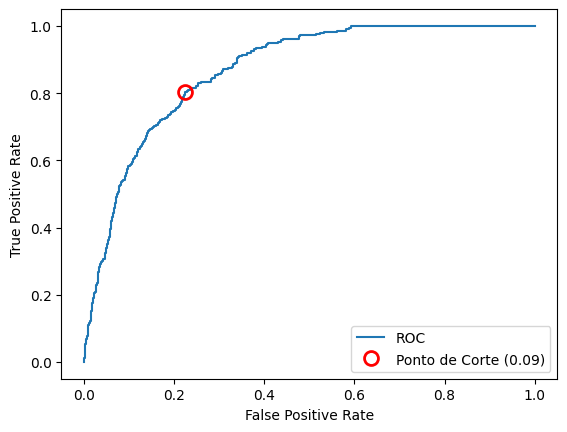

ROC AUC: 0.8679 Acurácia: 0.7776 Precisão: 0.2279 Recall: 0.8020
Matriz de Confusão:
 [[2751  796]
 [  58  235]]

Target:  {'Z_Scratch'}


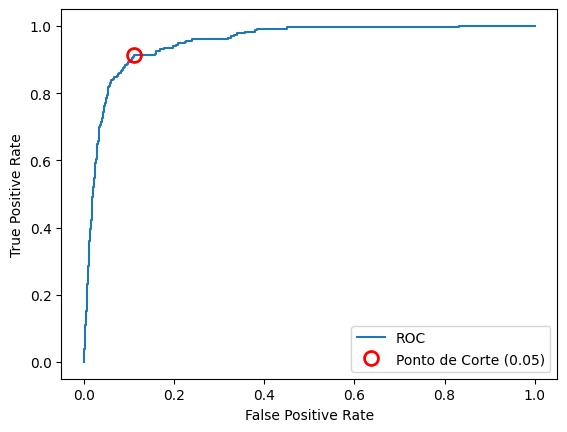

ROC AUC: 0.9512 Acurácia: 0.8904 Precisão: 0.3437 Recall: 0.9130
Matriz de Confusão:
 [[3209  401]
 [  20  210]]

Target:  {'K_Scatch'}


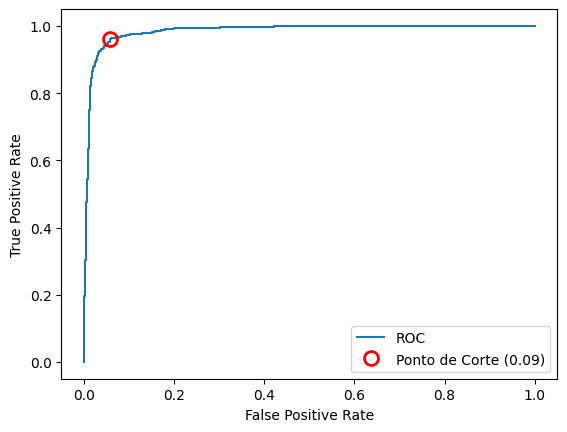

ROC AUC: 0.9847 Acurácia: 0.9456 Precisão: 0.7819 Recall: 0.9619
Matriz de Confusão:
 [[2975  183]
 [  26  656]]

Target:  {'Stains'}


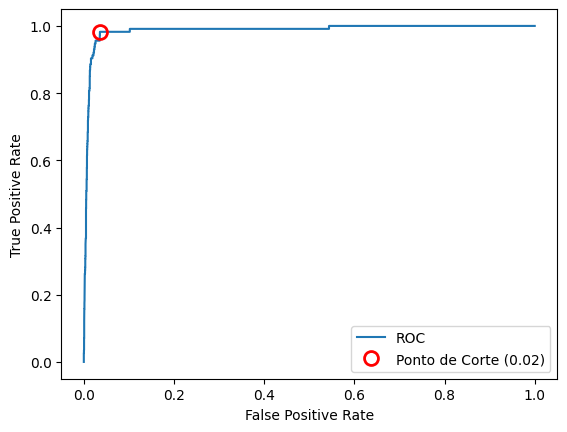

ROC AUC: 0.9870 Acurácia: 0.9648 Precisão: 0.4571 Recall: 0.9825
Matriz de Confusão:
 [[3593  133]
 [   2  112]]

Target:  {'Dirtiness'}


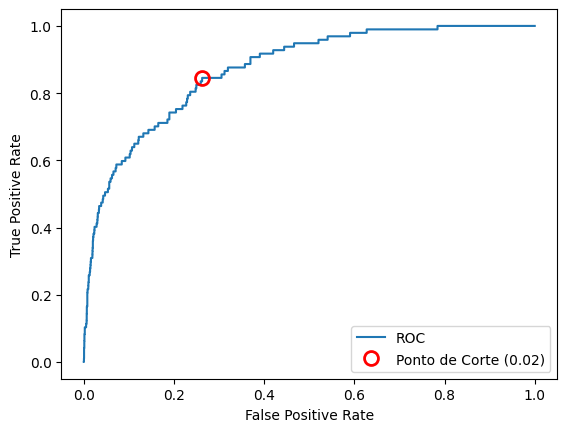

ROC AUC: 0.8719 Acurácia: 0.7404 Precisão: 0.0771 Recall: 0.8454
Matriz de Confusão:
 [[2761  982]
 [  15   82]]

Target:  {'Bumps'}


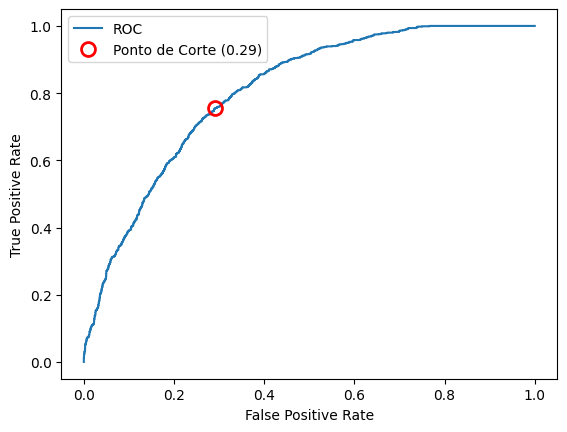

ROC AUC: 0.8054 Acurácia: 0.7208 Precisão: 0.4615 Recall: 0.7553
Matriz de Confusão:
 [[2049  839]
 [ 233  719]]

Target:  {'Other_Faults'}


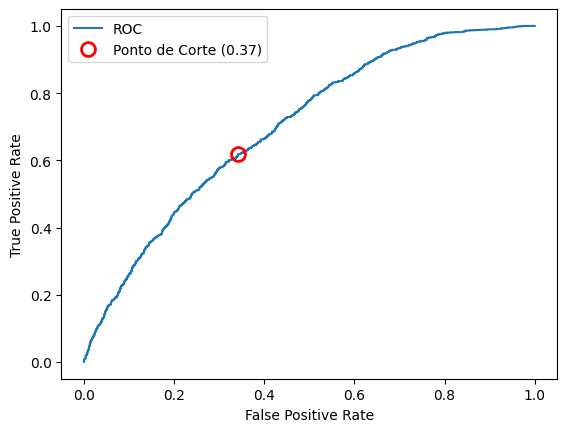

ROC AUC: 0.7009 Acurácia: 0.6440 Precisão: 0.4824 Recall: 0.6185
Matriz de Confusão:
 [[1664  868]
 [ 499  809]]

Average ROC AUC score across all targets: 0.8812809215992164 Acurácia:  0.8119419642857143 Precisão:  0.40451782456117585 Recall:  0.8397912410944114


In [31]:
models = []
predicts_teste01= []
for X_train, y_train, params in zip(X_train_list,y_train_list,param_list):
    # Treinando o modelo com todo o conjunto de treino
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    models.append(model)

auc_scores = []
acc_scores = []
pre_scores = []
rec_scores = []
print('Modelo: XGB')
for modelN, X_test, y_test in zip(models,X_test_list,y_test_list):
    print("\nTarget: ", {y_test.name})
    # Fazendo as predições com o conjunto de teste
    predictions_proba = modelN.predict_proba(X_test)
    # Trazendo apenas as probabilidades de ser 1
    predictions_positivo = predictions_proba[:, 1]

    # Trazendo dados para contrução da curva ROC para plot
    fpr, tpr, thresholds = roc_curve(y_test, predictions_positivo)
    # Calcula a distância euclidiana de cada ponto até (0,1)
    distances = np.sqrt((1-tpr)**2 + fpr**2)
    # Encontra o ponto com a menor distância
    best_index = np.argmin(distances)
    best_threshold = thresholds[best_index]
    best_fpr = fpr[best_index]
    best_tpr = tpr[best_index]

    # Plota a curva ROC
    plt.plot(fpr, tpr, label='ROC')
    plt.plot(best_fpr, best_tpr, 'o', markersize=10, label='Ponto de Corte (%0.2f)' %best_threshold, fillstyle="none", c='r', mew=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    predicts_teste01.append(predictions_positivo)
    # Tranformando as probabilidades acima de best_threshold em 1, para poder calcular a acurácia
    predictions_bin = np.where(predictions_positivo >= best_threshold, 1, 0)

    # Calculando as métricas
    roc_auc = roc_auc_score(y_test, predictions_positivo)
    accuracy = accuracy_score(y_test, predictions_bin)
    precision = precision_score(y_test, predictions_bin)
    recall = recall_score(y_test, predictions_bin)

    # Guardando para calculo de média do modelo
    auc_scores.append(roc_auc)
    acc_scores.append(accuracy)
    pre_scores.append(precision)
    rec_scores.append(recall)

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions_bin)

    # Imprimindo as métricas para o target atual
    print(f"ROC AUC: {roc_auc:.4f} Acurácia: {accuracy:.4f} Precisão: {precision:.4f} Recall: {recall:.4f}")
    print("Matriz de Confusão:\n", conf_matrix)

# Imprimindo as médias
average_auc_score = sum(auc_scores) / len(auc_scores)
average_accuracy_score = sum(acc_scores) / len(acc_scores)
average_precision_score = sum(pre_scores) / len(pre_scores)
average_recall_score = sum(rec_scores) / len(rec_scores)
print('\nAverage ROC AUC score across all targets:', average_auc_score, 'Acurácia: ', average_accuracy_score, 'Precisão: ', average_precision_score, 'Recall: ', average_recall_score)

**Comentários sobre os resultados do conjunto de teste**

O foco do problema é trazer a probabilidade de cada um dos erros, por isso estou priorizando trazer uma boa métrica de ROC AUC, entretanto para entender melhor a qualidade do modelo, resolvi avaliar nesse ponto outras métricas como acurácia, precisão, recall e verificação da matriz de confusão.

Acurácia está sempre trazendo valores altos (com média de 81%), devido ao fato dos dados serem muito desbalanceados, com isso ele facilmente acerta a classe majoritária trazendo muitos verdadeiro negativos. As tentativas de balancear o dataset com SMOTE e de colocar pesos na execução dos modelos, não mostraram nenhum tipo de ganho ao avaliar a métrica ROC AUC e por isso foram descartados.

Precisão / Recall: nas primeiras tentativas de avaliação dessa métrica, comparei as probabilidades com o valor fixo de 0.5, o que trouxe valores baixos tanto para precisão quanto para recall.
Com isso resolvi calcular um threshould (ponto de corte) baseado na menor distância euclidiana entre (0,1) e a curva ROC. Infelizemente alguns desses pontos de corte ficaram muito baixos fazendo com que eu tenha valores muito pequenos de precisão, mas como acredito que o foco é descobrir os Verdadeiros Positivos, ter uma maior quantidade de Falsos Positivos é aceitável. Consequentemente o modelo é capaz de trazer um número baixo de Falsos Negativos, resultado num bom Recall.




In [32]:
# Execução da predição nos dados de teste fornecidos pelo Kaggle
predicts_testeK01= []
for name, params in zip(y,param_list):
    model = xgb.XGBClassifier(**params)
    model.fit(X, y[name])

    predictions_proba = model.predict_proba(test_data[features])
    predictions_pos = predictions_proba[:, 1]
    predicts_testeK01.append(predictions_pos)

In [33]:
# Verificação das colunas de como deve ser a saída
subs.columns[1:]

Index(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps',
       'Other_Faults'],
      dtype='object')

In [34]:
# Cria um DataFrame com as probabilidades da classe positiva
probabilities_positive_array = np.array(predicts_testeK01).T
preds_df = pd.DataFrame(probabilities_positive_array, columns=subs.columns[1:])

# Adiciona a coluna 'id' ao DataFrame
preds_df = pd.concat([subs['id'],preds_df],axis=1)

# Cria uma saida com a resposta, que pode ser utilizada como entrega no Kaggle
# preds_df.to_csv('submission.csv', index=False) ### PRIMEIRO ENTREGA

# Imprime o DataFrame
print(preds_df)

          id    Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      19219  0.537559   0.001165  0.002571  0.000076   0.019268  0.173530   
1      19220  0.566772   0.020855  0.007816  0.000161   0.172138  0.136746   
2      19221  0.001120   0.049814  0.026423  0.000551   0.012676  0.297955   
3      19222  0.182344   0.001356  0.000431  0.001040   0.025188  0.372048   
4      19223  0.003089   0.001049  0.000387  0.004773   0.012921  0.571348   
...      ...       ...        ...       ...       ...        ...       ...   
12809  32028  0.080118   0.104865  0.002134  0.000123   0.041104  0.227867   
12810  32029  0.173153   0.005921  0.036033  0.018078   0.151141  0.159180   
12811  32030  0.000158   0.001020  0.930172  0.000147   0.001007  0.001874   
12812  32031  0.348049   0.021542  0.032894  0.000084   0.081737  0.149017   
12813  32032  0.000265   0.004222  0.891817  0.000164   0.001484  0.002001   

       Other_Faults  
0          0.345233  
1          0.333690

In [35]:
### Esse trecho server apenas para fazer a entrega no Kaggle e coleta da resposta do conjunto de teste disponibilizado por eles

# # Trazer arquivo do kaggle
# from google.colab import files
# files.upload()

# # Move e permissiona o arquivo do kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions submit -c "playground-series-s4e3" -f "submission.csv" -m "Colabs01 - Smote"

# Resultados ROC AUC

*   Retorno do Treino:  0,8882
*   Retorno do Teste:   0.8874
*   Resposta do conjunto de treino do Kaggle:  0,88821

**Comentários**

O resultado foi satisfatório mas vou ainda testar algumas hipóteses em relação a target "Other_Faults" já que teve o pior desempenho em ROC AUC e ainda não foi capaz de atingir uma boa nota de recall.
Isso deve ocorrer por essa coluna representar uma agregação de diversos outros problemas, sendo mais díficil a construção de uma única lógica de predição.

# Teste 02 - Criação de uma coluna com as probabilidades dos problemas já conhecidos

Nessa hipótese, irei gerar uma coluna que contém as probabilidades dos outros seis problemas ('Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps') e fazer o treino de um novo modelo usando isso como uma característica.
Dessa forma irei validar se o modelo vai ser capaz de identificar a característica "Problemas_Conhecidos" como algo relevante para a identificação da target "Other_Faults"

OBS: Boa parte das variáveis terá na composição do seu nome um número 2 no fim, para identificar que fazem parte do teste 2 (NOMEVARIAVEL2), dessa forma eu posso reaproveitar boa parte do código do primeiro modelo, sem perder as referências.

In [36]:
# Targets para capturar as probabilidades dos problemas conhecidos
targets2 = y.columns[:-1]
targets2

Index(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps'], dtype='object')

In [37]:
# Target final: Other_Faults
target2 = y.columns[-1:]
target2

Index(['Other_Faults'], dtype='object')

In [38]:
# Preparando os dados teste 2
X2 = train_data[features].copy()
# y2 será usado para modelagem das probabilidades dos problemas conhecidos
y2 = train_data[targets2].copy()
# yfinal2 será usado para modelagem da probabilidade de Other_Faults
yfinal2 = train_data[target2].copy()

In [39]:
# Criando um array para guardar as probabilidades geradas pela validação cruzada
probabilities2 = pd.DataFrame(index=X2.index, columns=y2.columns)

for Name in y2:
  # Com esse for, serei capaz de calcular a probabilidade de cada um dos folds, tendo no fim a probabilidade de todo conjunto de treino
  for train_index, test_index in kfold.split(X2, y2[Name]):
        X_train2, X_test2 = X2.iloc[train_index], X2.iloc[test_index]
        y_train2, y_test2 = y2[Name].iloc[train_index], y2[Name].iloc[test_index]

        model2 = xgb.XGBClassifier(**params)
        model2.fit(X_train2, y_train2)
        probs2 = model2.predict_proba(X_test2)[:, 1]  # Probabilidades da classe positiva
        probabilities2.loc[test_index, Name] = probs2

# Adicionando `Problemas_Conhecidos` como uma nova característica ao DataFrame
X2['Problemas_Conhecidos'] = probabilities2.max(axis=1)
X2.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Problemas_Conhecidos
0,584,590,909972,909977,16,8,5,2274,113,140,...,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0.82193
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0.455164
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0.903937
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0.140007
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0.130573


In [40]:
# Separação do holdout
# Variáveis de 'seed' e 'kfold' foram reaproveitadas
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, yfinal2, test_size=test_size, shuffle=True, random_state=seed, stratify=yfinal2)

In [60]:
# # Configurações para iteração de modelos
# models = [
#     ('XGB', XGBClassifier(random_state=seed)),
#     ('KNN', KNeighborsClassifier()),
#     ('LR', LogisticRegression(random_state=seed))
# ]

# results=[]

# # Configurações para iteração de padronização / normalização
# scalers = [None, StandardScaler(), MinMaxScaler()]
# # Configurações para iteração de balanceamento
# samplers = [None, SMOTE(random_state=seed)]
# # Configurações para iteração do SelectKbest
# k_values = [10, 20, 'all']

# # Loop para cada target y / modelo / scaler / samples / KBest
# for model_name, model in models:
#     ## Dessa vez mexer no balanceamento trouxe bons resultados e mantive no código
#     if model_name == 'LR':
#       model.set_params(class_weight='balanced')
#     for scaler in scalers:
#         for sampler in samplers:
#             for k in k_values:
#                 # Criação dos steps da Pipeline
#                 steps = []
#                 # Adicionando o scaler
#                 if scaler is not None:
#                     steps.append(('scaler', scaler))
#                 # Adicionando o sampler
#                 if sampler is not None:
#                     steps.append(('sampler', sampler))
#                 # Adicionando SelectKBest
#                 steps.append(('selectkbest', SelectKBest(score_func=f_classif, k=k)))
#                 # Adicionando o modelo
#                 steps.append(('classifier', model))

#                 pipeline = imblearnPipeline(steps=steps)

#                 # Realizando a validação cruzada
#                 cv_results = cross_validate(pipeline, X_train2, y_train2, cv=kfold, scoring=['roc_auc', 'accuracy'])

#                 roc_auc_mean = np.mean(cv_results['test_roc_auc'])
#                 accuracy_mean = np.mean(cv_results['test_accuracy'])

#                 # Armazenando os resultados, incluindo o valor de k
#                 results.append({
#                     'target': 'Other_Faults',
#                     'model': model_name,
#                     'scaler': 'None' if scaler is None else scaler.__class__.__name__,
#                     'sampler': 'None' if sampler is None else 'SMOTE',
#                     'k': k,
#                     'roc_auc': roc_auc_mean,
#                     'accuracy': accuracy_mean
#                 })

# # Imprimindo cada resultado individualmente
# for result in results:
#     print(f"Target: {result['target']}, Model: {result['model']}, Scaler: {result['scaler']}, Sampler: {result['sampler']}, KBest: {result['k']}, ROC AUC: {result['roc_auc']:.4f}, Accuracy: {result['accuracy']:.4f}")

# # Imprimindo o Top 10 Combinações Globais
# global_averages = {}
# for result in results:
#     combination_key = (result['model'], result['scaler'], result['sampler'], result['k'])
#     if combination_key not in global_averages:
#         global_averages[combination_key] = {'roc_auc': [], 'accuracy': []}
#     global_averages[combination_key]['roc_auc'].append(result['roc_auc'])
#     global_averages[combination_key]['accuracy'].append(result['accuracy'])

# for key, value in global_averages.items():
#     avg_roc_auc = sum(value['roc_auc']) / len(value['roc_auc'])
#     avg_accuracy = sum(value['accuracy']) / len(value['accuracy'])
#     value['avg_roc_auc'] = avg_roc_auc
#     value['avg_accuracy'] = avg_accuracy

# # Ordenando as combinações gerais pela média de ROC AUC em ordem decrescente
# sorted_global_combinations = sorted(global_averages.items(), key=lambda x: x[1]['avg_roc_auc'], reverse=True)

# print("\nTop 10 Combinações Gerais Baseadas na Média do ROC AUC:")
# for i, ((model, scaler, sampler, k), metrics) in enumerate(sorted_global_combinations[:10], start=1):
#     print(f"{i}. Modelo: {model}, Scaler: {'No Scaler' if scaler == 'None' else scaler}, Sampler: {'No Sampler' if sampler == 'None' else 'SMOTE'}, KBest: {k}, Média ROC AUC: {metrics['avg_roc_auc']:.4f}, Média de Acurácia: {metrics['avg_accuracy']:.4f}")

**O código acima foi comentado por demorar cerca de 5 minutos. Saída:**

```
Top 10 Combinações Gerais Baseadas na Média do ROC AUC:
1. Modelo: LR, Scaler: MinMaxScaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.6977, Média de Acurácia: 0.6091
2. Modelo: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.6975, Média de Acurácia: 0.6090
3. Modelo: LR, Scaler: StandardScaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.6972, Média de Acurácia: 0.6095
4. Modelo: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.6969, Média de Acurácia: 0.6097
5. Modelo: LR, Scaler: MinMaxScaler, Sampler: No Sampler, KBest: 20, Média ROC AUC: 0.6955, Média de Acurácia: 0.6081
6. Modelo: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, Média ROC AUC: 0.6953, Média de Acurácia: 0.6068
7. Modelo: LR, Scaler: StandardScaler, Sampler: No Sampler, KBest: 20, Média ROC AUC: 0.6951, Média de Acurácia: 0.6075
8. Modelo: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, Média ROC AUC: 0.6949, Média de Acurácia: 0.6072
9. Modelo: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 10, Média ROC AUC: 0.6918, Média de Acurácia: 0.6063
10. Modelo: LR, Scaler: MinMaxScaler, Sampler: No Sampler, KBest: 10, Média ROC AUC: 0.6917, Média de Acurácia: 0.6066
```



**Com os resultados obtidos, cheguei as seguintes conclusões:**
*   O algoritmo de LR apresentou melhores resultados do que o XGB e será utilizado nessa etapa.
*   Dessa vez os melhores resultados vieram dos conjuntos que foram padronizados ou normalizados, então estarei utilizando a normalização nessa etapa.

In [42]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])

    # Escolhendo solver apropriado para o penalty
    if penalty == 'none':
        solver = 'lbfgs'  # 'lbfgs' é eficiente para 'none'
    elif penalty in ['l1', 'elasticnet']:
        solver = 'saga'  # 'saga' suporta 'l1' e 'elasticnet'
    else:
        solver = trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cg', 'liblinear'])

    param = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e+6),
        'penalty': penalty,
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

    if penalty == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
    if penalty in ['l1', 'elasticnet', 'none']:
        param['solver'] = solver

    # Scaler aplicado para Optuna já que teve melhor desempenho para essa etapa
    scaler = MinMaxScaler()
    X_train_scaled2 = scaler.fit_transform(X_train2)
    X_test_scaled2 = scaler.transform(X_test2)

    model = LogisticRegression(**param)

    model.fit(X_train_scaled2, y_train2)
    preds = model.predict_proba(X_test_scaled2)[:, 1]
    auc = roc_auc_score(y_test2, preds)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

param_list2 = study.best_trial.params

# Resolvendo o problema do Solver não ser trazido na lista de parâmetros
if param_list2['penalty'] in ['l1', 'elasticnet']:
    param_list2['solver'] = 'saga'
elif param_list2['penalty'] == 'none':
    param_list2['solver'] = 'lbfgs'
else:
    param_list2['solver'] = 'lbfgs'

print('Target:', 'Other_Faults')
print('Number of finished trials:', len(study.trials))
print('Best trial:', param_list2)
print('Best ROC AUC score:', study.best_trial.value)


Target: Other_Faults
Number of finished trials: 100
Best trial: {'penalty': 'l1', 'C': 0.2668450253939782, 'max_iter': 590, 'solver': 'saga'}
Best ROC AUC score: 0.699898787870004


Modelo: LR

Target: Other_Faults


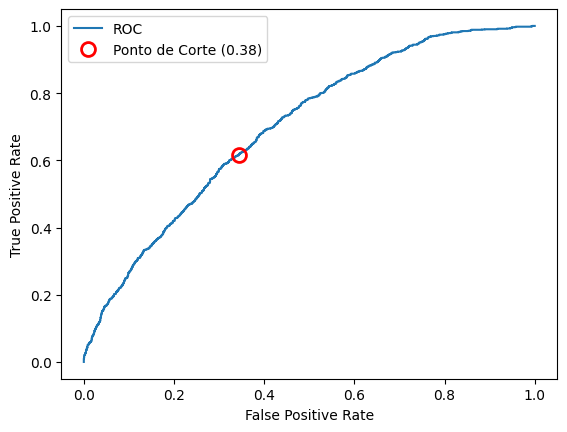

ROC AUC: 0.6999 Acurácia: 0.6427 Precisão: 0.4809 Recall: 0.6170
Matriz de Confusão:
 [[1661  871]
 [ 501  807]]


In [43]:
predicts_teste02= []

# Criando um modelo com todo o conjunto de treino
scaler = MinMaxScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

model = LogisticRegression(**param_list2)
model.fit(X_train_scaled2, y_train2)

print('Modelo: LR')
print("\nTarget: Other_Faults")
# Fazendo as predições com o conjunto de teste
predictions_proba2 = model.predict_proba(X_test_scaled2)
# Trazendo apenas as probabilidades de ser 1
predictions_positivo2 = predictions_proba2[:, 1]

# Trazendo dados para contrução da curva ROC para plot
fpr2, tpr2, thresholds2 = roc_curve(y_test2, predictions_positivo2)
# Calcula a distância euclidiana de cada ponto até (0,1)
distances2 = np.sqrt((1-tpr2)**2 + fpr2**2)
# Encontra o ponto com a menor distância
best_index2 = np.argmin(distances2)
best_threshold2 = thresholds2[best_index]
best_fpr2 = fpr2[best_index]
best_tpr2 = tpr2[best_index]

# Plota a curva ROC
plt.plot(fpr2, tpr2, label='ROC')
plt.plot(best_fpr2, best_tpr2, 'o', markersize=10, label='Ponto de Corte (%0.2f)' %best_threshold2, fillstyle="none", c='r', mew=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

predicts_teste02.append(predictions_positivo2)
# Tranformando as probabilidades acima de best_threshold em 1, para poder calcular a acurácia
predictions_bin2 = np.where(predictions_positivo2 >= best_threshold2, 1, 0)

# Calculando as métricas
roc_auc2 = roc_auc_score(y_test2, predictions_positivo2)
accuracy2 = accuracy_score(y_test2, predictions_bin2)
precision2 = precision_score(y_test2, predictions_bin2)
recall2 = recall_score(y_test2, predictions_bin2)

# Matriz de confusão
conf_matrix2 = confusion_matrix(y_test2, predictions_bin2)

# Imprimindo as métricas para o target atual
print(f"ROC AUC: {roc_auc2:.4f} Acurácia: {accuracy2:.4f} Precisão: {precision2:.4f} Recall: {recall2:.4f}")
print("Matriz de Confusão:\n", conf_matrix2)

**Comentários sobre os resultados do conjunto de teste**

O ROC AUC da target Other_Faults do teste 2 teve uma pequena perda em relação ao primeiro modelo, fazendo com que essa idéia não agregue valor ao modelo e com isso será descartada como hipótese.



# Teste 03 - Utilização de Aprendizado Não Supervisionado na target Other_Faults

Nessa hipótese irei focar em tornar a característica "*Other_Faults*" menos genérica. Por definição, ela é uma agregação de todos os outros problemas que possuem menos ocorrências do que o menor problema da lista de problemas conhecidos, no caso, menos do que 485 registros de "*Dirtiness*".

OBS: Boa parte das variáveis terá na composição do seu nome um número 3 no fim, para identificar que fazem parte do teste 3 (NOMEVARIAVEL3), dessa forma eu posso reaproveitar boa parte do código do primeiro modelo, sem perder as referências.


In [44]:
df_other = pd.concat([X,y['Other_Faults']],axis=1)

# Pega apenas Other_Faults iguais a 1 para trabalhar o agrupamento
df_group_check = df_other[df_other['Other_Faults'] == 1]
df_group_check = df_group_check.drop('Other_Faults', axis=1)
df_group_check

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998
5,1009,1033,899231,899307,409,22,26,47513,86,118,...,0.0053,0.5454,1.0000,1.0,2.6117,0.9542,1.4150,0.5909,-0.1890,0.8749
11,1313,1324,2421293,2421292,116,27,29,9120,105,127,...,0.0126,0.5294,0.9310,1.0,2.0645,1.2305,1.4624,0.7097,-0.0631,0.2901
13,974,985,1211728,1211795,81,14,13,9137,148,182,...,0.0066,0.6429,0.9231,1.0,1.9085,0.9542,1.1139,0.3077,0.3146,0.2253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19187,1116,1151,203973,203987,240,20,29,28061,118,135,...,0.0089,0.7500,0.4483,0.0,2.3802,1.0792,1.3010,-0.1667,-0.0118,0.7659
19190,1327,1332,1266537,1266548,52,9,14,5249,90,118,...,0.0044,0.6667,1.0000,1.0,1.7160,0.7782,1.1461,0.5714,-0.2069,0.1753
19192,0,28,4662945,4662964,9484,179,200,1320194,19,108,...,0.0148,0.2383,0.9857,1.0,3.9815,1.3010,2.2967,0.9362,-0.2947,1.0000
19194,723,735,2488529,2488541,231,17,26,27135,104,133,...,0.0065,0.7333,0.9216,1.0,2.3636,1.0414,1.4150,0.7222,-0.0989,0.5378


In [45]:
#Referencia - Deve ser menor que 485 (menor valor da lista)
train_data[targets].value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      1               6540
                                                1      0               4761
                   1         0       0          0      0               3411
1       0          0         0       0          0      0               1465
0       1          0         0       0          0      0               1150
        0          0         0       0          0      0                818
                             1       0          0      0                568
                             0       1          0      0                485
Name: count, dtype: int64

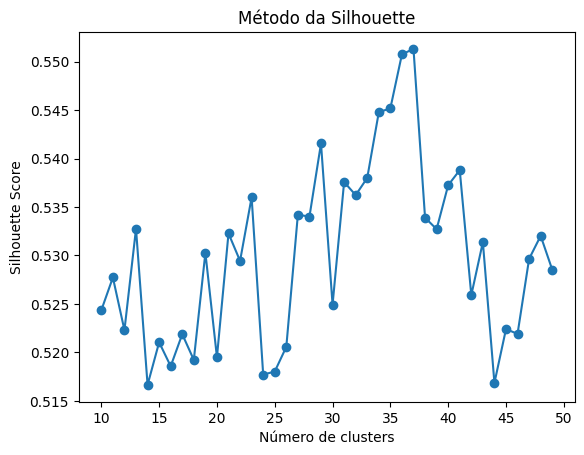

In [46]:
# # Scalers - Utilização de scalers diminui muito a verificação do Silhouette Score
# scaler3 = StandardScaler()
# df_group_check = scaler3.fit_transform(df_group_check)

# Lista de números de clusters a serem testados
num_clusters = list(range(10, 50))

# Lista vazia para armazenar a Silhouette Score para cada número de clusters
silhouette_scores = []

# Calcular a Silhouette Score para cada número de clusters
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(df_group_check)
    score = silhouette_score(df_group_check, kmeans.labels_)
    silhouette_scores.append(score)

# Plotar a curva da Silhouette Score
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Método da Silhouette')
plt.show()

In [47]:
# Melhor Silhouette Score: 37
n_clusters = 37

kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(df_group_check)

# Obter os rótulos dos grupos para cada amostra
labels = kmeans.labels_

# Adicionar os rótulos como uma nova coluna no data frame original
df_group_check['problem'] = labels

df_group_check['problem'].value_counts()

problem
8     878
0     628
22    619
23    556
5     548
10    508
24    460
2     283
27    276
12    272
25    220
21    202
13    138
4     130
1      98
16     90
28     62
34     62
6      60
35     59
31     54
33     52
3      45
26     43
19     36
29     25
20     22
11     20
18     19
15     19
32     12
14     12
9       8
7       8
17      8
30      5
36      3
Name: count, dtype: int64

In [48]:
# Separa a coluna 'group' em N colunas com 0 e 1 usando get_dummies
df_dummies = pd.get_dummies(df_group_check['problem'], prefix='problem', dtype=int)

# Concatena o dataframe original com as novas colunas criadas
df_dummies = pd.concat([df_group_check, df_dummies], axis=1)

# Remove a coluna 'group' original
df_dummies = df_dummies.drop('problem', axis=1)

df_dummies.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,problem_27,problem_28,problem_29,problem_30,problem_31,problem_32,problem_33,problem_34,problem_35,problem_36
1,808,816,728350,728372,433,20,54,44478,70,111,...,0,0,0,0,0,0,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0,0,0,0,0,0,0,0,0,0
5,1009,1033,899231,899307,409,22,26,47513,86,118,...,0,0,0,0,0,0,0,0,0,0
11,1313,1324,2421293,2421292,116,27,29,9120,105,127,...,0,0,0,0,0,0,0,0,0,0
13,974,985,1211728,1211795,81,14,13,9137,148,182,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Calcula as contagens de cada classe/coluna.
class_counts = df_dummies[df_dummies.columns[-37:]].apply(lambda x: x.sum())

# Desconsiderando as classes/colunas com menos do que 30 ocorrências. Estavam gerando erro no resto do processo pela pequena amostragem.
classes_to_keep = class_counts[class_counts >= 30].index

# Filtra o conjunto de dados para manter apenas as colunas com amostras suficientes.
df_dummies_filtered = df_dummies[classes_to_keep]
df_dummies_filtered

,problem_0,problem_1,problem_2,problem_3,problem_4,problem_5,problem_6,problem_8,problem_10,problem_12,...,problem_23,problem_24,problem_25,problem_26,problem_27,problem_28,problem_31,problem_33,problem_34,problem_35
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19187,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19190,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19194,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [50]:
targets3=list(df_dummies_filtered.columns)
targets3

['problem_0',
 'problem_1',
 'problem_2',
 'problem_3',
 'problem_4',
 'problem_5',
 'problem_6',
 'problem_8',
 'problem_10',
 'problem_12',
 'problem_13',
 'problem_16',
 'problem_19',
 'problem_21',
 'problem_22',
 'problem_23',
 'problem_24',
 'problem_25',
 'problem_26',
 'problem_27',
 'problem_28',
 'problem_31',
 'problem_33',
 'problem_34',
 'problem_35']

In [51]:
X3=df_dummies[features].copy()
y3=df_dummies[targets3].copy()

In [52]:
X_train_list3 = []
X_test_list3 = []
y_train_list3 = []
y_test_list3 = []

for Name in y3:
    X_train, X_test, y_train, y_test = train_test_split(X3, y3[Name], test_size=test_size, shuffle=True, random_state=seed, stratify=y3)
    X_train_list3.append(X_train)
    X_test_list3.append(X_test)
    y_train_list3.append(y_train)
    y_test_list3.append(y_test)

In [59]:
# # Configurações para iteração de modelos
# models = [
#     ('XGB', XGBClassifier(random_state=seed)),
#     #('RF', RandomForestClassifier(random_state=seed)),
#     #('SVC', SVC(probability=True, random_state=seed)),  # probability=True para permitir predict_proba
#     ('KNN', KNeighborsClassifier()),
#     ('LR', LogisticRegression(random_state=seed))
# ]

# # Configurações para iteração de padronização / normalização
# scalers = [None, StandardScaler(), MinMaxScaler()]
# # Configurações para iteração de balanceamento
# samplers = [None, SMOTE(random_state=seed)]
# # Configurações para iteração do SelectKbest
# k_values = [10, 20, 'all']

# # Lista para guardar os resultados
# results = []

# # Loop para cada target y / modelo / scaler / samples / KBest
# for X_train, y_train in zip(X_train_list3,y_train_list3):
#     for model_name, model in models:
#         ## Esse trecho foi uma tentativa de melhorar os modelos dando mais peso para a classe positiva, porém não deram resultado positivo e foram removidos
#         # scale_pos_weight_value = (y_train.size - y_train.sum()) / y_train.sum()
#         # if model_name == 'XGB':
#         #   model.set_params(scale_pos_weight=scale_pos_weight_value)
#         # if model_name == 'LR':
#         #   model.set_params(class_weight='balanced')
#         for scaler in scalers:
#             for sampler in samplers:
#                 for k in k_values:
#                     # Criação dos steps da Pipeline
#                     steps = []
#                     # Adicionando o scaler
#                     if scaler is not None:
#                         steps.append(('scaler', scaler))
#                     # Adicionando o sampler
#                     if sampler is not None:
#                         steps.append(('sampler', sampler))
#                     # Adicionando SelectKBest
#                     steps.append(('selectkbest', SelectKBest(score_func=f_classif, k=k)))
#                     # Adicionando o modelo
#                     steps.append(('classifier', model))

#                     pipeline = imblearnPipeline(steps=steps)

#                     # Realizando a validação cruzada
#                     cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=['roc_auc', 'accuracy'])

#                     roc_auc_mean = np.mean(cv_results['test_roc_auc'])
#                     accuracy_mean = np.mean(cv_results['test_accuracy'])

#                     # Armazenando os resultados, incluindo o valor de k
#                     results.append({
#                         'target': y_train.name,
#                         'model': model_name,
#                         'scaler': 'None' if scaler is None else scaler.__class__.__name__,
#                         'sampler': 'None' if sampler is None else 'SMOTE',
#                         'k': k,
#                         'roc_auc': roc_auc_mean,
#                         'accuracy': accuracy_mean
#                     })

# # Imprimindo cada resultado individualmente
# for result in results:
#     print(f"Target: {result['target']}, Model: {result['model']}, Scaler: {result['scaler']}, Sampler: {result['sampler']}, KBest: {result['k']}, ROC AUC: {result['roc_auc']:.4f}, Accuracy: {result['accuracy']:.4f}")

# # Imprimindo o Top 10 Combinações Globais
# global_averages = {}
# for result in results:
#     combination_key = (result['model'], result['scaler'], result['sampler'], result['k'])
#     if combination_key not in global_averages:
#         global_averages[combination_key] = {'roc_auc': [], 'accuracy': []}
#     global_averages[combination_key]['roc_auc'].append(result['roc_auc'])
#     global_averages[combination_key]['accuracy'].append(result['accuracy'])

# for key, value in global_averages.items():
#     avg_roc_auc = sum(value['roc_auc']) / len(value['roc_auc'])
#     avg_accuracy = sum(value['accuracy']) / len(value['accuracy'])
#     value['avg_roc_auc'] = avg_roc_auc
#     value['avg_accuracy'] = avg_accuracy

# # Ordenando as combinações gerais pela média de ROC AUC em ordem decrescente
# sorted_global_combinations = sorted(global_averages.items(), key=lambda x: x[1]['avg_roc_auc'], reverse=True)

# print("\nTop 10 Combinações Gerais Baseadas na Média do ROC AUC:")
# for i, ((model, scaler, sampler, k), metrics) in enumerate(sorted_global_combinations[:10], start=1):
#     print(f"{i}. Modelo: {model}, Scaler: {'No Scaler' if scaler == 'None' else scaler}, Sampler: {'No Sampler' if sampler == 'None' else 'SMOTE'}, KBest: {k}, Média ROC AUC: {metrics['avg_roc_auc']:.4f}, Média de Acurácia: {metrics['avg_accuracy']:.4f}")

# # Imprimindo a melhor combinação por Target para avaliar desempenho individual
# best_combinations_by_target = {}
# for target_name in y3.columns:
#     target_results = [result for result in results if result['target'] == target_name]
#     best_combination = max(target_results, key=lambda x: x['roc_auc'])
#     best_combinations_by_target[target_name] = best_combination

# print("\nMelhor Combinação por Target Baseada no ROC AUC:")
# for target_name, best_combination in best_combinations_by_target.items():
#     print(f"Target: {target_name}, Modelo: {best_combination['model']}, Scaler: {best_combination['scaler']}, Sampler: {best_combination['sampler']}, KBest: {best_combination['k']}, ROC AUC: {best_combination['roc_auc']:.4f}, Acurácia: {best_combination['accuracy']:.4f}")

# # Imprimindo a média geral de ROC AUC e Acurácia das melhores combinações por target
# roc_auc_values = [best_combination['roc_auc'] for best_combination in best_combinations_by_target.values()]
# accuracy_values = [best_combination['accuracy'] for best_combination in best_combinations_by_target.values()]
# avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)
# avg_accuracy = sum(accuracy_values) / len(accuracy_values)

# print(f"\nMédia de ROC AUC para as melhores combinações por Target: {avg_roc_auc:.4f}")
# print(f"Média de Acurácia para as melhores combinações por Target: {avg_accuracy:.4f}")



**Código acima foi comentado por demorar mais de 30 min. Saída:**

OBS: Removi as saídas individuais, para facilitar a visualização
```

Top 10 Combinações Gerais Baseadas na Média do ROC AUC:
1. Modelo: XGB, Scaler: No Scaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.9996, Média de Acurácia: 0.9980
2. Modelo: XGB, Scaler: StandardScaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.9996, Média de Acurácia: 0.9980
3. Modelo: XGB, Scaler: MinMaxScaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.9996, Média de Acurácia: 0.9980
4. Modelo: KNN, Scaler: No Scaler, Sampler: No Sampler, KBest: all, Média ROC AUC: 0.9994, Média de Acurácia: 0.9992
5. Modelo: KNN, Scaler: No Scaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.9993, Média de Acurácia: 0.9989
6. Modelo: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.9993, Média de Acurácia: 0.9980
7. Modelo: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.9992, Média de Acurácia: 0.9980
8. Modelo: XGB, Scaler: No Scaler, Sampler: SMOTE, KBest: all, Média ROC AUC: 0.9991, Média de Acurácia: 0.9984
9. Modelo: XGB, Scaler: No Scaler, Sampler: SMOTE, KBest: 20, Média ROC AUC: 0.9863, Média de Acurácia: 0.9949
10. Modelo: KNN, Scaler: No Scaler, Sampler: SMOTE, KBest: 20, Média ROC AUC: 0.9855, Média de Acurácia: 0.9872

Melhor Combinação por Target Baseada no ROC AUC:
Target: problem_0, Modelo: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, ROC AUC: 0.9999, Acurácia: 0.9968
Target: problem_1, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 1.0000
Target: problem_2, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 0.9992
Target: problem_3, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 1.0000
Target: problem_4, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9999, Acurácia: 0.9992
Target: problem_5, Modelo: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 1.0000, Acurácia: 0.9996
Target: problem_6, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 1.0000
Target: problem_8, Modelo: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 0.9987
Target: problem_10, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 0.9998
Target: problem_12, Modelo: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 1.0000, Acurácia: 1.0000
Target: problem_13, Modelo: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9999, Acurácia: 0.9979
Target: problem_16, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 1.0000
Target: problem_19, Modelo: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9999, Acurácia: 0.9992
Target: problem_21, Modelo: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 1.0000, Acurácia: 0.9989
Target: problem_22, Modelo: XGB, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9999, Acurácia: 0.9985
Target: problem_23, Modelo: XGB, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9999, Acurácia: 0.9964
Target: problem_24, Modelo: KNN, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 1.0000, Acurácia: 0.9990
Target: problem_25, Modelo: XGB, Scaler: None, Sampler: None, KBest: 10, ROC AUC: 0.9998, Acurácia: 0.9973
Target: problem_26, Modelo: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 1.0000, Acurácia: 0.9996
Target: problem_27, Modelo: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9999, Acurácia: 0.9983
Target: problem_28, Modelo: KNN, Scaler: None, Sampler: SMOTE, KBest: all, ROC AUC: 0.9997, Acurácia: 0.9979
Target: problem_31, Modelo: KNN, Scaler: None, Sampler: None, KBest: 20, ROC AUC: 0.9999, Acurácia: 0.9987
Target: problem_33, Modelo: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 0.9999, Acurácia: 0.9992
Target: problem_34, Modelo: KNN, Scaler: None, Sampler: None, KBest: all, ROC AUC: 1.0000, Acurácia: 0.9992
Target: problem_35, Modelo: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, ROC AUC: 0.9997, Acurácia: 0.9989

Média de ROC AUC para as melhores combinações por Target: 0.9999
Média de Acurácia para as melhores combinações por Target: 0.9989
```



**Análise das métricas:**

*   O top 10 de combinações gerais apresenta métricas muito próximas, o que me permite escolher o XGB por ter resultado em tempos de execução mais rápidos do que os outros algoritmos testa
*   Apesar da melhor saída não utilizar SMOTE, eu optei por usar assim mesmo, uma vez que nossos dados são extremamente desbalanceadas nessa abordagem.
*   Com os bons resultados, não vejo necessidade de descobrir os melhores hiperparametros.






Modelo: XGB

Target:  {'problem_0'}


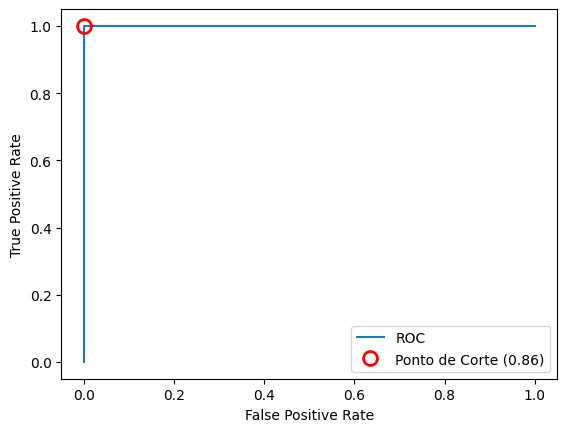

ROC AUC: 1.0000 Acurácia: 0.9992 Precisão: 0.9921 Recall: 1.0000
Matriz de Confusão:
 [[1181    1]
 [   0  126]]

Target:  {'problem_1'}


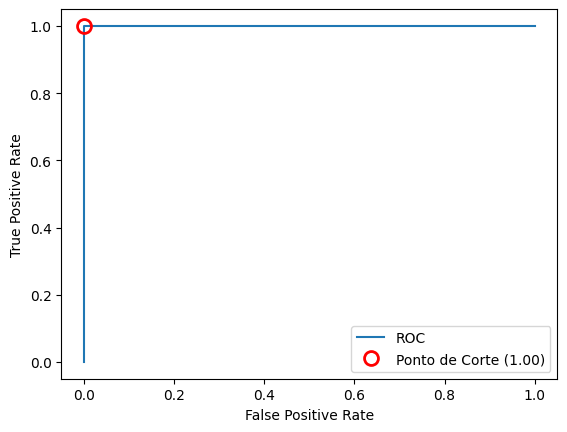

ROC AUC: 0.9998 Acurácia: 0.9992 Precisão: 0.9524 Recall: 1.0000
Matriz de Confusão:
 [[1287    1]
 [   0   20]]

Target:  {'problem_2'}


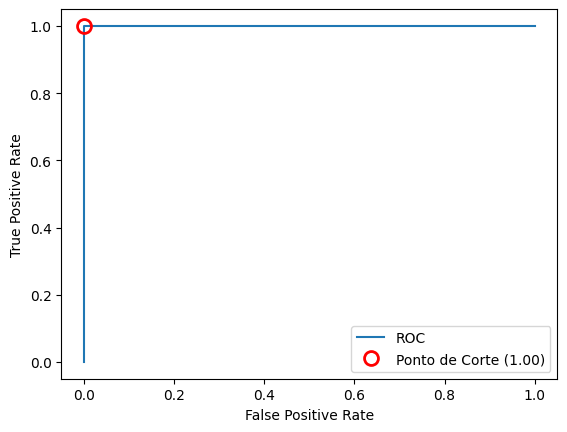

ROC AUC: 1.0000 Acurácia: 1.0000 Precisão: 1.0000 Recall: 1.0000
Matriz de Confusão:
 [[1251    0]
 [   0   57]]

Target:  {'problem_3'}


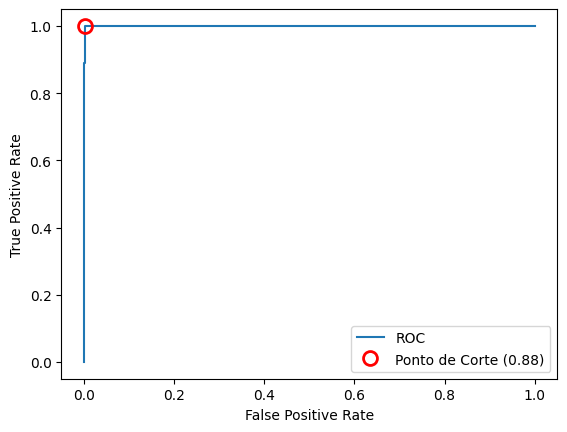

ROC AUC: 0.9997 Acurácia: 0.9985 Precisão: 0.8182 Recall: 1.0000
Matriz de Confusão:
 [[1297    2]
 [   0    9]]

Target:  {'problem_4'}


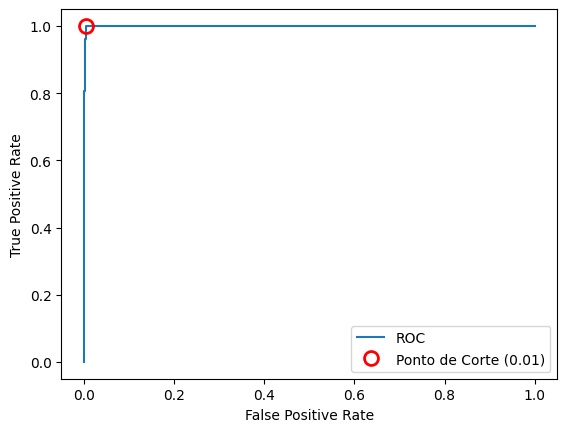

ROC AUC: 0.9994 Acurácia: 0.9954 Precisão: 0.8125 Recall: 1.0000
Matriz de Confusão:
 [[1276    6]
 [   0   26]]

Target:  {'problem_5'}


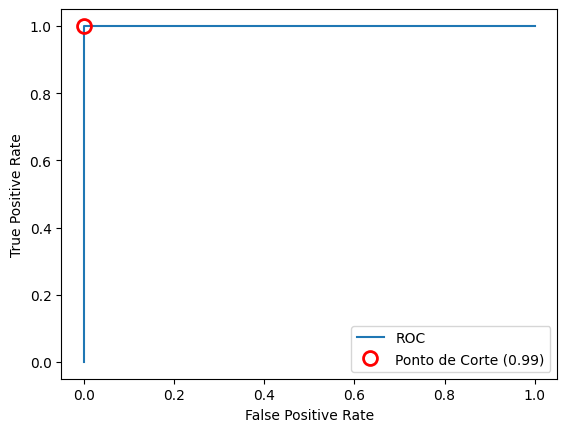

ROC AUC: 1.0000 Acurácia: 1.0000 Precisão: 1.0000 Recall: 1.0000
Matriz de Confusão:
 [[1198    0]
 [   0  110]]

Target:  {'problem_6'}


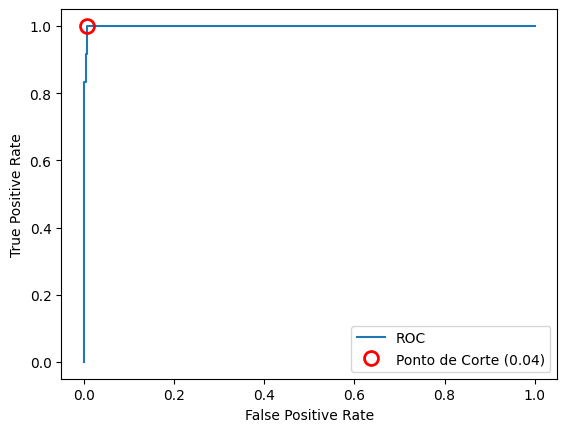

ROC AUC: 0.9992 Acurácia: 0.9939 Precisão: 0.6000 Recall: 1.0000
Matriz de Confusão:
 [[1288    8]
 [   0   12]]

Target:  {'problem_8'}


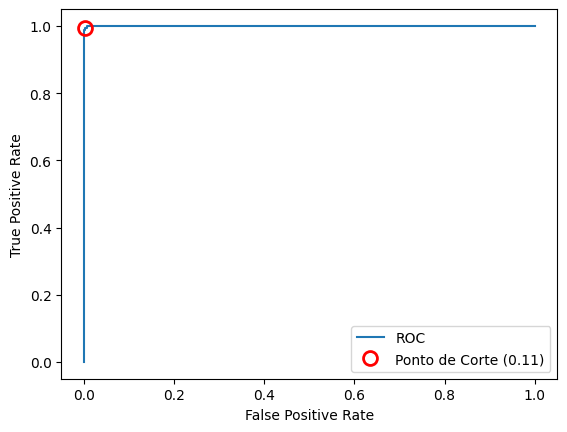

ROC AUC: 0.9999 Acurácia: 0.9969 Precisão: 0.9831 Recall: 0.9943
Matriz de Confusão:
 [[1129    3]
 [   1  175]]

Target:  {'problem_10'}


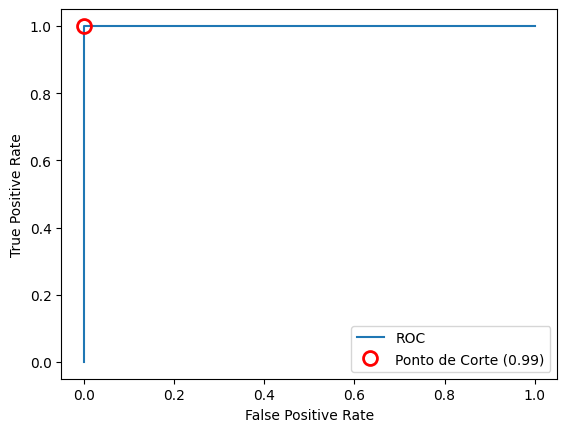

ROC AUC: 1.0000 Acurácia: 0.9992 Precisão: 0.9903 Recall: 1.0000
Matriz de Confusão:
 [[1205    1]
 [   0  102]]

Target:  {'problem_12'}


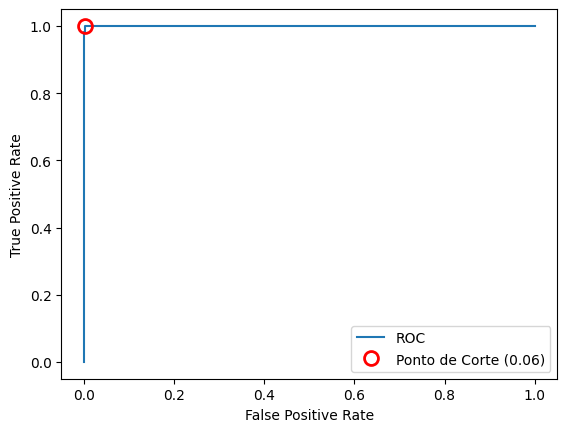

ROC AUC: 0.9999 Acurácia: 0.9985 Precisão: 0.9643 Recall: 1.0000
Matriz de Confusão:
 [[1252    2]
 [   0   54]]

Target:  {'problem_13'}


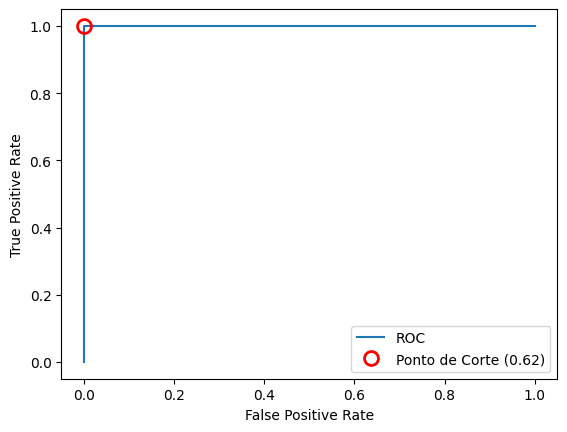

ROC AUC: 0.9999 Acurácia: 0.9992 Precisão: 0.9643 Recall: 1.0000
Matriz de Confusão:
 [[1280    1]
 [   0   27]]

Target:  {'problem_16'}


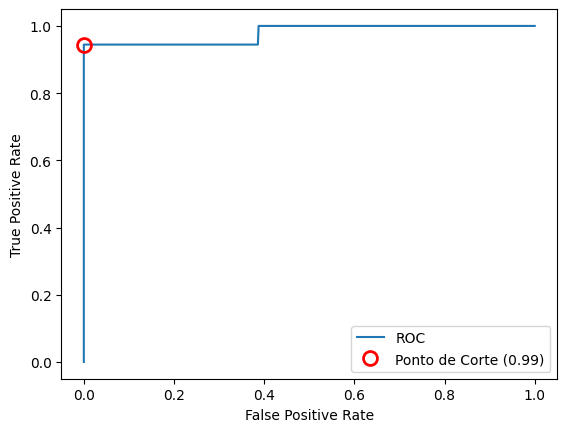

ROC AUC: 0.9785 Acurácia: 0.9992 Precisão: 1.0000 Recall: 0.9444
Matriz de Confusão:
 [[1290    0]
 [   1   17]]

Target:  {'problem_19'}


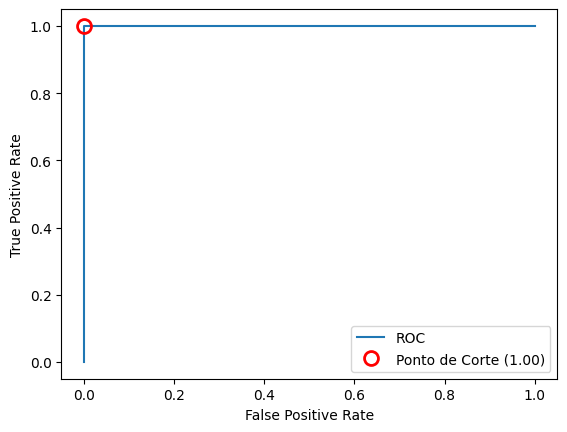

ROC AUC: 0.9996 Acurácia: 0.9992 Precisão: 0.8750 Recall: 1.0000
Matriz de Confusão:
 [[1300    1]
 [   0    7]]

Target:  {'problem_21'}


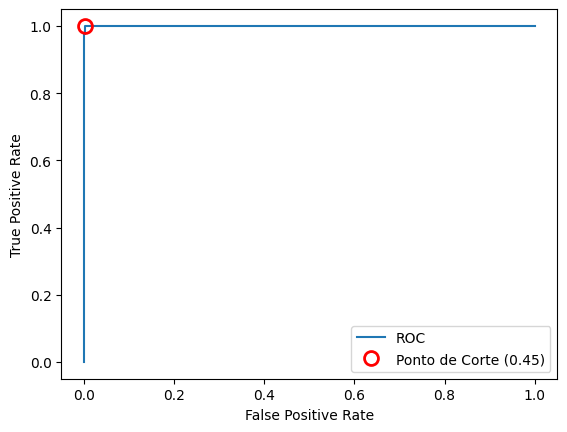

ROC AUC: 1.0000 Acurácia: 0.9985 Precisão: 0.9524 Recall: 1.0000
Matriz de Confusão:
 [[1266    2]
 [   0   40]]

Target:  {'problem_22'}


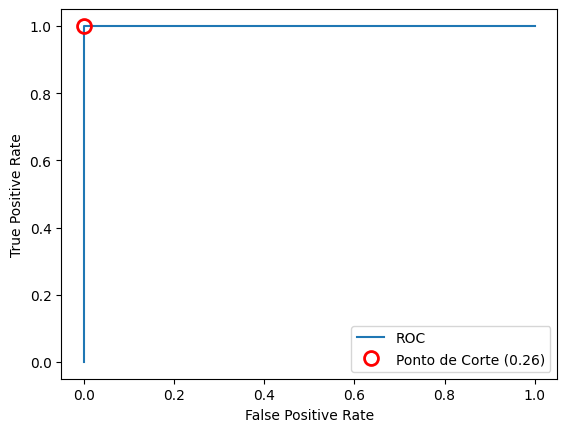

ROC AUC: 1.0000 Acurácia: 1.0000 Precisão: 1.0000 Recall: 1.0000
Matriz de Confusão:
 [[1184    0]
 [   0  124]]

Target:  {'problem_23'}


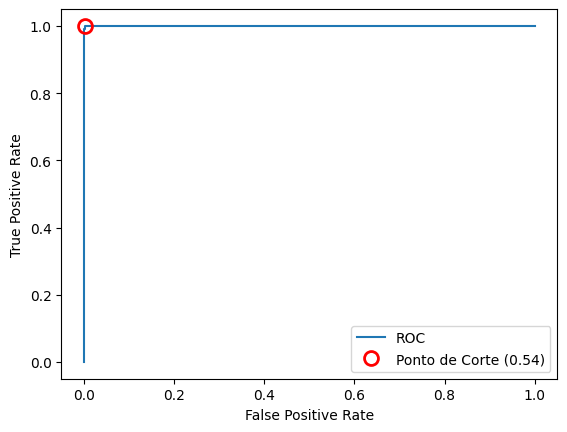

ROC AUC: 1.0000 Acurácia: 0.9985 Precisão: 0.9823 Recall: 1.0000
Matriz de Confusão:
 [[1195    2]
 [   0  111]]

Target:  {'problem_24'}


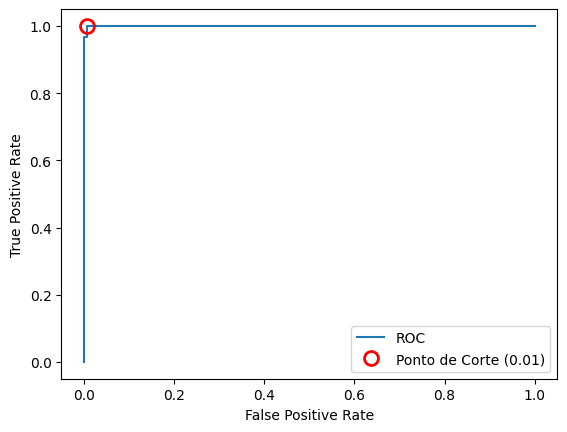

ROC AUC: 0.9998 Acurácia: 0.9931 Precisão: 0.9109 Recall: 1.0000
Matriz de Confusão:
 [[1207    9]
 [   0   92]]

Target:  {'problem_25'}


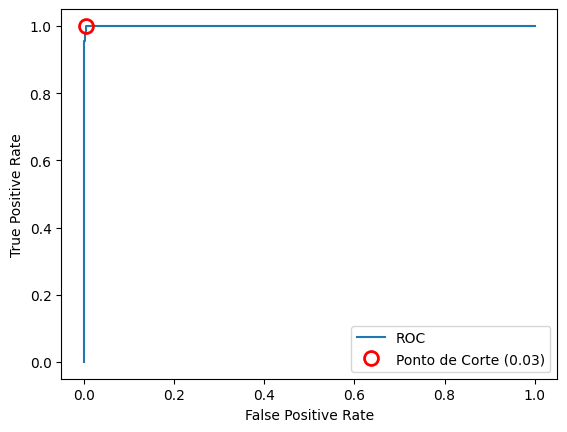

ROC AUC: 0.9999 Acurácia: 0.9962 Precisão: 0.8980 Recall: 1.0000
Matriz de Confusão:
 [[1259    5]
 [   0   44]]

Target:  {'problem_26'}


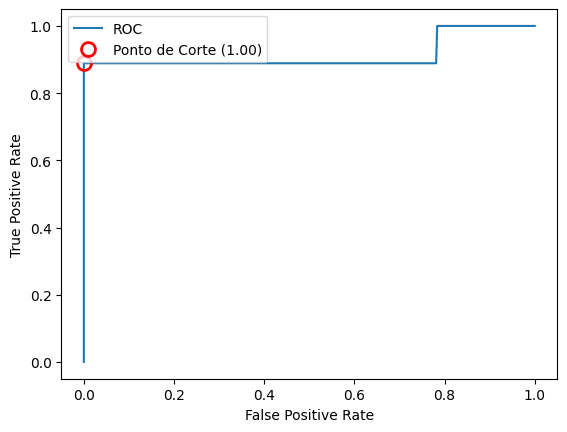

ROC AUC: 0.9131 Acurácia: 0.9992 Precisão: 1.0000 Recall: 0.8889
Matriz de Confusão:
 [[1299    0]
 [   1    8]]

Target:  {'problem_27'}


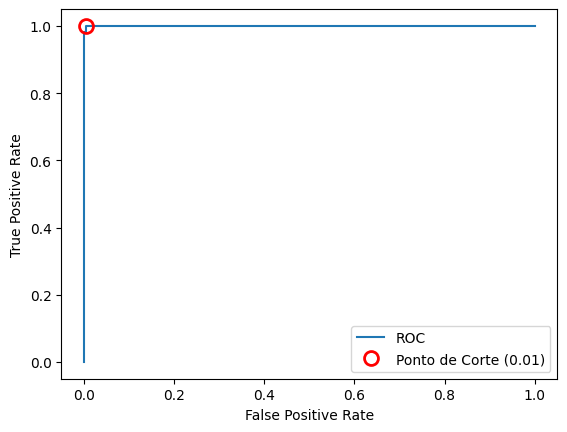

ROC AUC: 0.9999 Acurácia: 0.9962 Precisão: 0.9167 Recall: 1.0000
Matriz de Confusão:
 [[1248    5]
 [   0   55]]

Target:  {'problem_28'}


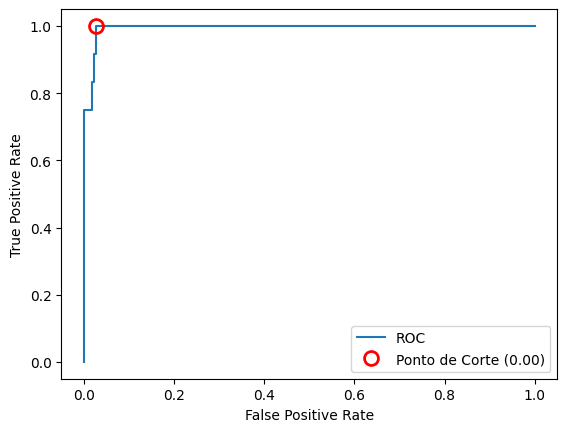

ROC AUC: 0.9943 Acurácia: 0.9725 Precisão: 0.2500 Recall: 1.0000
Matriz de Confusão:
 [[1260   36]
 [   0   12]]

Target:  {'problem_31'}


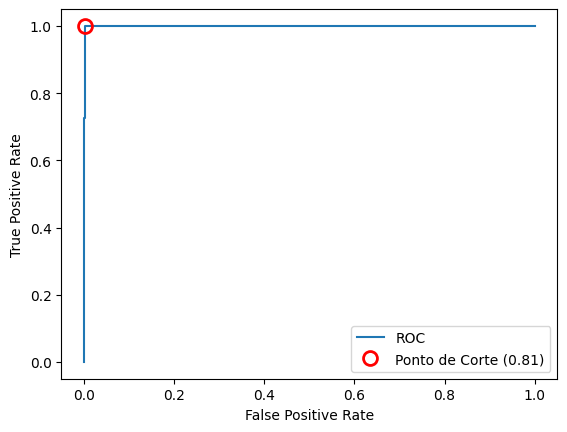

ROC AUC: 0.9996 Acurácia: 0.9985 Precisão: 0.8462 Recall: 1.0000
Matriz de Confusão:
 [[1295    2]
 [   0   11]]

Target:  {'problem_33'}


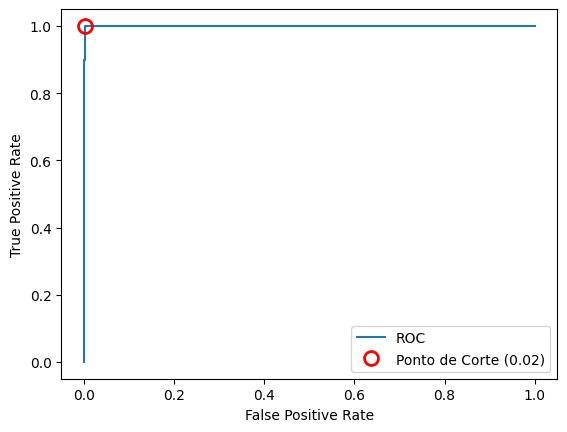

ROC AUC: 0.9997 Acurácia: 0.9969 Precisão: 0.7143 Recall: 1.0000
Matriz de Confusão:
 [[1294    4]
 [   0   10]]

Target:  {'problem_34'}


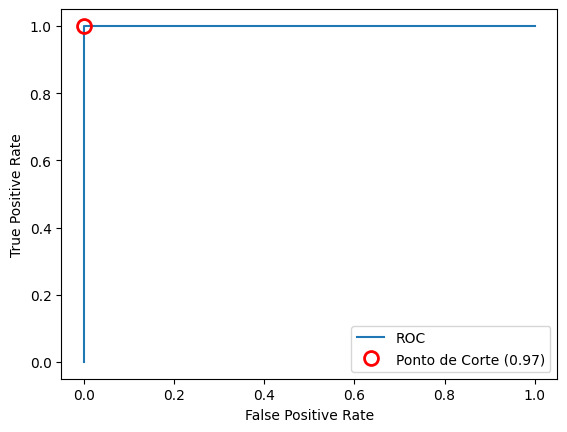

ROC AUC: 1.0000 Acurácia: 1.0000 Precisão: 1.0000 Recall: 1.0000
Matriz de Confusão:
 [[1296    0]
 [   0   12]]

Target:  {'problem_35'}


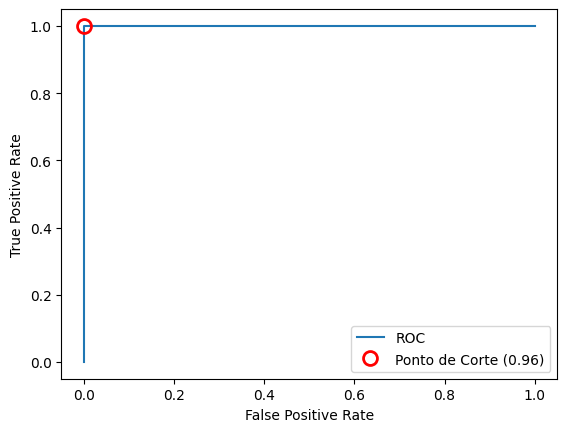

ROC AUC: 1.0000 Acurácia: 1.0000 Precisão: 1.0000 Recall: 1.0000
Matriz de Confusão:
 [[1296    0]
 [   0   12]]

Average ROC AUC score across all targets: 0.9952875728599168 Acurácia:  0.997125382262997 Precisão:  0.8969134340065252 Recall:  0.9931060606060607


In [54]:
# Verificação do modelo
models3 = []
predicts_teste03= []
for X_train3, y_train3 in zip(X_train_list3,y_train_list3):
    # Utilizar SMOTE nessa etapa aumentou drásticamente a precisão
    smote3 = SMOTE(random_state=seed)
    X_train3, y_train3 = smote3.fit_resample(X_train3, y_train3)
    # Criando um modelo com todo o conjunto de treino
    model3 = xgb.XGBClassifier()
    model3.fit(X_train3, y_train3)
    models3.append(model3)

auc_scores3 = []
acc_scores3 = []
pre_scores3 = []
rec_scores3 = []
print('Modelo: XGB')
for modelN3, X_test3, y_test3 in zip(models3,X_test_list3,y_test_list3):
    print("\nTarget: ", {y_test3.name})
    # Fazendo as predições com o conjunto de teste
    predictions_proba3 = modelN3.predict_proba(X_test3)
    # Trazendo apenas as probabilidades de ser 1
    predictions_positivo3 = predictions_proba3[:, 1]

    # Trazendo dados para contrução da curva ROC para plot
    fpr3, tpr3, thresholds3 = roc_curve(y_test3, predictions_positivo3)
    # Calcula a distância euclidiana de cada ponto até (0,1)
    distances3 = np.sqrt((1-tpr3)**2 + fpr3**2)
    # Encontra o ponto com a menor distância
    best_index3 = np.argmin(distances3)
    best_threshold3 = thresholds3[best_index3]
    best_fpr3 = fpr3[best_index3]
    best_tpr3 = tpr3[best_index3]

    # Plota a curva ROC
    plt.plot(fpr3, tpr3, label='ROC')
    plt.plot(best_fpr3, best_tpr3, 'o', markersize=10, label='Ponto de Corte (%0.2f)' %best_threshold3, fillstyle="none", c='r', mew=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    predicts_teste03.append(predictions_positivo3)
    # Tranformando as probabilidades acima de best_threshold em 1, para poder calcular a acurácia
    predictions_bin3 = np.where(predictions_positivo3 >= best_threshold3, 1, 0)

    # Calculando as métricas
    roc_auc3 = roc_auc_score(y_test3, predictions_positivo3)
    accuracy3 = accuracy_score(y_test3, predictions_bin3)
    precision3 = precision_score(y_test3, predictions_bin3)
    recall3 = recall_score(y_test3, predictions_bin3)

    # Guardando para calculo de média do modelo
    auc_scores3.append(roc_auc3)
    acc_scores3.append(accuracy3)
    pre_scores3.append(precision3)
    rec_scores3.append(recall3)

    # Matriz de confusão
    conf_matrix3 = confusion_matrix(y_test3, predictions_bin3)

    # Imprimindo as métricas para o target atual
    print(f"ROC AUC: {roc_auc3:.4f} Acurácia: {accuracy3:.4f} Precisão: {precision3:.4f} Recall: {recall3:.4f}")
    print("Matriz de Confusão:\n", conf_matrix3)

# Imprimindo as médias
average_auc_score3 = sum(auc_scores3) / len(auc_scores3)
average_accuracy_score3 = sum(acc_scores3) / len(acc_scores3)
average_precision_score3 = sum(pre_scores3) / len(pre_scores3)
average_recall_score3 = sum(rec_scores3) / len(rec_scores3)
print('\nAverage ROC AUC score across all targets:', average_auc_score3, 'Acurácia: ', average_accuracy_score3, 'Precisão: ', average_precision_score3, 'Recall: ', average_recall_score3)

**Análise dos resultados**

Os algoritmos se mostraram muito eficazes em predizer esses grupos criados pelo KMeans.

In [55]:
# Execução da predição nos dados de teste fornecidos pelo Kaggle
predicts_testeK03= []
for name in y3:
    smote3 = SMOTE(random_state=seed)
    X3_smote, y3_smote = smote3.fit_resample(X3,y3[name])

    model3 = xgb.XGBClassifier()
    model3.fit(X3_smote, y3_smote)

    predictions_proba3 = model3.predict_proba(test_data[features])
    predictions_pos3 = predictions_proba3[:, 1]
    predicts_testeK03.append(predictions_pos3)

In [56]:
probabilities_positive_array3 = np.array(predicts_testeK03).T

# Cria um DataFrame com as probabilidades da classe positiva
preds_df3 = pd.DataFrame(probabilities_positive_array3)

# Encontra o valor máximo para cada linha
other_faults3 = preds_df3.max(axis=1)

# Cria uma nova coluna com o valor máximo
other_faults_df = pd.DataFrame(other_faults3, columns=["Other_Faults"])

# Adiciona a coluna 'id' ao DataFrame
preds_df_final = pd.concat([preds_df.iloc[:, :7],other_faults_df["Other_Faults"]],axis=1)
#saida
preds_df_final.to_csv('submission.csv', index=False)

# Imprime o DataFrame
print(preds_df_final)

          id    Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      19219  0.537559   0.001165  0.002571  0.000076   0.019268  0.173530   
1      19220  0.566772   0.020855  0.007816  0.000161   0.172138  0.136746   
2      19221  0.001120   0.049814  0.026423  0.000551   0.012676  0.297955   
3      19222  0.182344   0.001356  0.000431  0.001040   0.025188  0.372048   
4      19223  0.003089   0.001049  0.000387  0.004773   0.012921  0.571348   
...      ...       ...        ...       ...       ...        ...       ...   
12809  32028  0.080118   0.104865  0.002134  0.000123   0.041104  0.227867   
12810  32029  0.173153   0.005921  0.036033  0.018078   0.151141  0.159180   
12811  32030  0.000158   0.001020  0.930172  0.000147   0.001007  0.001874   
12812  32031  0.348049   0.021542  0.032894  0.000084   0.081737  0.149017   
12813  32032  0.000265   0.004222  0.891817  0.000164   0.001484  0.002001   

       Other_Faults  
0          0.999819  
1          0.999917

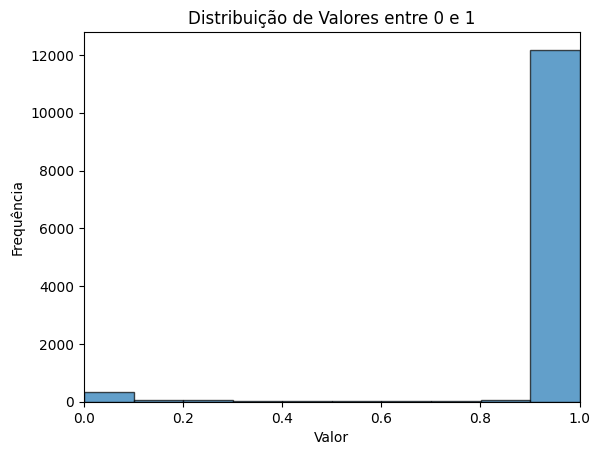

In [57]:
# Verificação da distribuição de valores na coluna "Other_Faults"
plt.hist(other_faults_df.values.flatten(), bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.title('Distribuição de Valores entre 0 e 1')
plt.xlim(0, 1)  # Garantir que o eixo X varie de 0 a 1
plt.show()

**Comentários sobre os resultados do conjunto de teste**

Apesar dos resultados terem sido muito bons modelos de treino e teste, quando trago os dados de treino disponibilizados pelo Kaggle, esse modelos tendem a quase sempre considerar que um dos problemas está contido no "Other_Faults".
Com isso, essa hipótese também foi descartada.

# **Conclusão final**

O modelo inicial demonstrou ser o mais eficaz e foi selecionado como a solução ideal para este problema. Embora os Testes 01 e 02 não tenham alcançado os resultados esperados, foram fundamentais para o enriquecimento do projeto, proporcionando a oportunidade de integrar novas teorias e aprofundar os estudos.

In [61]:
#Trazendo novamente a saída final:
print(preds_df)

          id    Pastry  Z_Scratch  K_Scatch    Stains  Dirtiness     Bumps  \
0      19219  0.537559   0.001165  0.002571  0.000076   0.019268  0.173530   
1      19220  0.566772   0.020855  0.007816  0.000161   0.172138  0.136746   
2      19221  0.001120   0.049814  0.026423  0.000551   0.012676  0.297955   
3      19222  0.182344   0.001356  0.000431  0.001040   0.025188  0.372048   
4      19223  0.003089   0.001049  0.000387  0.004773   0.012921  0.571348   
...      ...       ...        ...       ...       ...        ...       ...   
12809  32028  0.080118   0.104865  0.002134  0.000123   0.041104  0.227867   
12810  32029  0.173153   0.005921  0.036033  0.018078   0.151141  0.159180   
12811  32030  0.000158   0.001020  0.930172  0.000147   0.001007  0.001874   
12812  32031  0.348049   0.021542  0.032894  0.000084   0.081737  0.149017   
12813  32032  0.000265   0.004222  0.891817  0.000164   0.001484  0.002001   

       Other_Faults  
0          0.345233  
1          0.333690